# qppenalty

This notebook generates the `qppenalty` programs in C, Python, NodeJS-Javascript and Java.
These approaches generate similar results but not the exact same result.
This code has only been lightly tested as a proof of concept.

`qppenalty` programs read a quadratic programming problem and writes out the optimal solution.
Run this notebook in a directory where the source code and example problem files can be written.

This notebook has the following components:
- [Review](#Review) of mathematical approach to solving the quadratic problem.
- [Description](#Algorithm-Description) of the implementation.
  - [Source Code](#Source-Code)
    - [Matrix Utilities](#Matrix-Utilities)
    - [Optimization Utilities](#Optimization-Utilities)
    - [Minimization](#Minimization)
- [Prepare code](#Prepare-code)
- [Example problems](#Problems)
- [Optimization path plot](#Optimization-path-plot)

`qppenalty` runs correctly on these simple test problems.
It shows considerable sensitivity to the learning rate parameter, so it should be selected with care.
If the rate is too high, results may diverge.
A more sophisticated driver could detect this situation and reduce the rate as needed.
Since the penalty term is quadratic when $\mu\to 0$ even small penalties generate large errors.
So, another possible solution might be to use a absolute difference term for the penalty.

## Review

The algorithm solves an unconstrained penalty function minimization problem that approximates the constrained quadratic programming problem.
Each time the penalty minimization is solved, the penalty function is updated to put more emphasis on the constraints penalty. Further information on the underlying mathematics can be found in [Numerical Optimization, Nocedal & Wright, 2006](https://www.google.com/search?q=Numerical+Optimization%2C+Nocedal+%26+Wright%2C+2006)

The quadratic programming problem is:

\begin{align}
Minimize      && f(x) = \frac{1}{2} x^t A x + b^{t}x && x \in \mathbb{R}^n\\
subject\ to   && c_i x + d_i - s_i = 0 && \begin{cases}
s_i = 0,\space i\in I=\{0,1,2,\ldots,n-1\}\\
s_i \ge 0,\space i\in J=\{n+0,n+1,n+2,\ldots,m+n-1\}\\
\end{cases}
\end{align} 

The first $n$ constraints are equality constraints and the next $m$
constraints are inequality constraints for a total of $n+m$ constraints.
$A$ is assumed to be symmetric and positive definite.
Each $c_i$ is a row in the constraint matrix $C$.

The Lagrangian, with solution $x^*, s^*, \lambda^*$, is:

$$
L(x,s,\lambda) = f(x) - \sum_{i\in I,J}\lambda_i(c_ix + d_i - s_i),\space
s_i \ge 0,\space
\lambda_i \ge 0\space
\forall i\in J
$$

Define a penalty function of $\mu$, with solution $x_{\mu}^*, s_{\mu}^*, \lambda_{\mu}^*$ as:

$$
P_{\mu}(x,s,\lambda) = f(x)
- \sum_{i \in I,J}\lambda_i (c_ix + d_i - s_i)
+ \frac{1}{2\mu}\sum_{i \in I,J}(c_ix + d_i - s_i)^2
\space s_i \ge 0,
\space \lambda_i \ge 0
\space\forall i\in J
$$

Now consider the optimal value for $s_{\mu}$:

\begin{align}
&&\frac{\partial P_{\mu}(x_\mu,s_\mu,\lambda_\mu)}{\partial s_{\mu,i}} = 0 = \lambda_{\mu,i} - \frac{1}{\mu}(c_ix_\mu + d_i - s_{\mu,i})\\
&&s_{\mu,i} = c_ix_\mu + d_i - \mu\lambda_{\mu,i}
\end{align} 

Note that $s_{\mu,i} = c_ix{\mu,i} + d_{\mu,i}$ as $\mu\to 0$ or when $\lambda_i=0$.
Recall that $s_{\mu,i} \ge 0\space\forall i \in J$. So:

$$
s_{\mu,i}^* = \begin{cases}
0 && i \in I\\
0 && c_ix + d_i < \mu\lambda_{\mu,i}, i \in J\\
c_ix_\mu + d_i - \mu\lambda_{\mu,i} && otherwise
\end{cases}
$$

Let $s_\mu^* = (s_{\mu,0}^*, s_{\mu,1}^*, s_{\mu,2}^*, \ldots)$.
The minimization problem becomes:

$$
Minimize\space
P_{\mu}(x_\mu,s_\mu^*,\lambda_\mu) = f(x)
- \sum_{i\in I,J}\lambda_{\mu,i} (c_ix_\mu + d_i - s_{\mu,i}^*)
+ \frac{1}{2\mu}\sum_{i\in I,J}(c_ix_\mu + d_i - s_{\mu,i}^*)^2
,\space \lambda_{\mu,i} \ge 0
$$
So:
$$
    \nabla_x P_\mu(x_\mu,s_\mu^*,\lambda_\mu) = 0 = Ax_\mu + b - \lambda_\mu^t Cx + \frac{C}{\mu}(Cx_\mu+d-s_\mu)
$$

Let $\mu_k$ be the kth element of a sequence of $\mu \to 0$.
The following important results are used:
- As $x_{\mu_k}^* \to x^*$, then $P_{\mu}(x_{\mu_k}^*,s_\mu^*,\lambda) \to L(x^*,s_\mu^*,\lambda)$.
- Since the $x_{\mu_k}^*$ are KKT points for $P_{\mu}(x,s_\mu^*,\lambda)$, $\lambda$ can be refined with:
  $\lambda_{k+1} = \lambda_{k} - (Cx + d - s_{\mu}^*)/u$
- These $\lambda \to \lambda^*$.

Recall that $\lambda_i\ge 0\space\forall i\in J$. So:
$$
\lambda_{i_{k+1}} = \begin{cases}
0 && \lambda_{i_{k}} \lt (c_ix_\mu + d_i - s_{i,\mu}^*)/u,\space\forall i\in J\\
\lambda_{i_{k}} - (c_ix_\mu + d_i - s_{i,\mu}^*)/u && otherwise
\end{cases}
$$

$\lambda_{\mu}^*$ is the limit of the sequence of $\lambda_k =
(\lambda_{0_{k}}, \lambda_{1_{k}}\lambda_{2_{k}}, \ldots)$ for a given $\mu$.

Finally:
$$
P_{\mu}(x_\mu^*,s_\mu^*,\lambda_{\mu}^*) \to L(x^*,s^*,\lambda^*)
\space as
\space \mu \to 0
$$

## Algorithm Description

The computational algorithm iteratively steps towards the minimum of $P_\mu(x,s,\lambda)$ and then updates $s$ and $\lambda$.
It is important to have a good solution, but not necessarily an exact solution, to the minimization of $P_\mu(x,s,\lambda)$ for the intermediate values of $\mu$
as long as $x_\mu$ is close to $x_\mu^*$.
Once $\nabla P_\mu(x,s,\lambda)$ is near 0, the penalty function parameter $\mu$ is adjusted towards 0.

In addition $\mu$ may be too relaxed for the constraints.
This means that the constraints are not driving $x$ towards the feasible region.
In this case, $\mu$ will be updated whenever
${||Cx + d - s_{\mu}^*||}_2$ $\gt$ $||{\nabla\mathbb{P}(x)||}_2$.
The constraints norm is a measure of the sensitivity of the $\lambda$ values.
This condition ensures that the constraints have enough influence over the solution
and that they are met before the minimum is achieved.

This implementation uses gradient descendent for the minimization itself.
This allows for a large number of dimensions in the problem.

## Source Code

The source code in this notebook is organized by operation, not by language.
Readers should read the cells with their preferred language.
Interested readers can than review the code differences between the languages.
The code blocks use the `%%writefile` magic in the Python notebook.
The first code cell for each language overwrites the `qppenalty` source file;
subsequent cells append to this file.
Care must be used in the Python code to ensure that the code is properly indented.
The programs should compile with no errors.
Lower level functions are defined first, with the `main` function at the bottom of the file.
The notebook must be run from the top to correctly generate the source files.
Typically each cell contains a single function.
The code was developed in this notebook, first in C, followed by Python, NodeJS-Javascript and Java.
Sometimes with terse compiler error messages, I resorted to the generated code.
Some code refactoring was tedious without a good editor.
C needed the most lines of code, while Javascript needed the most characters.
This code is so simple that class structures didn't really improve the code.
But I used classes to control namespace pollution.
I note that the java compiler was the most conservative, type-sensitive and careful.
I enabled unused variable warnings in the C compiler, but the Java compiler caught
issues that `lint` would have caught in C.
This code has not been performance optimized,
instead the emphasis is on minimizing dependencies.
About half the code is dedicated to reading in the problem.

There are 4 levels of progressive details available:
0. (default) Solution is displayed.
1. Problem description and summary optimization steps are displayed.
2. Details of the optimization state are displayed.
3. Memory allocation and deallocations are displayed.

### Includes

Required includes are stated.

In [1]:
%%writefile qppenalty.c
#include <stdio.h>
#include <stdlib.h>
#include <stdarg.h>
#include <string.h>
#include <ctype.h>
#include <math.h>

Overwriting qppenalty.c


In [2]:
%%writefile qppenalty.py
from math import sqrt

Overwriting qppenalty.py


In [3]:
%%writefile qppenalty.java
import java.lang.Math;
import java.io.BufferedReader;
import java.io.InputStreamReader;

Overwriting qppenalty.java


### format in Javascript

In Javascript add `format` method on String class to simplify text formatting: tokens like '{0}' and '{1}' are replaced by the corresponding argument.

In [4]:
%%writefile qppenalty.js


String.prototype.format = function() {
    var key;
    var result;

    result = this;
    for (key in arguments)
        result = result.replace("{" + key + "}", arguments[key].toString());

    return result;
}

Overwriting qppenalty.js


### Detail level

Declare `qppenalty` class, as necessary, and the level of `details` to report.

In [5]:
%%writefile -a qppenalty.c


static int details = 0; /* level of detail to report */

Appending to qppenalty.c


In [6]:
%%writefile -a qppenalty.py


class qppenalty:
    def __init__(self):
        self.details = 0 # level of detail to report

Appending to qppenalty.py


In [7]:
%%writefile -a qppenalty.js


function qppenalty() {
    this.details = 0; // level of detail to report

Appending to qppenalty.js


In [8]:
%%writefile -a qppenalty.java

class qppenalty {
    private int details = 0; // level of detail to report

Appending to qppenalty.java


### error

Simple error handling that exits the program on an error after printing a message.

In [9]:
%%writefile -a qppenalty.c


static void error(char *text) {
  fprintf(stderr, "ERROR: %s\n", text);
  exit(1);
}

Appending to qppenalty.c


In [10]:
%%writefile -a qppenalty.py


    def error(self, text):
        print("ERROR: " + text)
        raise ValueError(text)
        return

Appending to qppenalty.py


In [11]:
%%writefile -a qppenalty.js


    this.error = function(self, text) {
        console.log("ERROR: " + text);
        process.exit(1);
    }

Appending to qppenalty.js


In [12]:
%%writefile -a qppenalty.java


    private void error(String text) {
        System.out.println("ERROR: " + text);
        System.exit(1);
    }

Appending to qppenalty.java


### details

The detail family of functions display an information line depending on the level of detailed requested.

In [13]:
%%writefile -a qppenalty.c


static void detail_level(int level, char *text) {
  if (details >= level)
    fprintf(stdout, "INFO: %s\n", text);
}

#define detail(text) detail_level(0, text)
#define detail0(text) detail_level(0, text)
#define detail1(text) detail_level(1, text)
#define detail2(text) detail_level(2, text)
#define detail3(text) detail_level(3, text)

Appending to qppenalty.c


In [14]:
%%writefile -a qppenalty.py


    def detail_level(self, level, text):
        if self.details >= level:
            print('INFO: %s' % text)
        return

    detail = lambda self, text: self.detail_level(0, text);
    detail0 = lambda self, text: self.detail_level(0, text);
    detail1 = lambda self, text: self.detail_level(1, text);
    detail2 = lambda self, text: self.detail_level(2, text);
    detail3 = lambda self, text: self.detail_level(3, text);

Appending to qppenalty.py


In [15]:
%%writefile -a qppenalty.js


    this.detail_level = function(level, text) {
        if (this.details >= level)
            console.log("INFO: " + text);
    }

    this.detail = function(text) { this.detail_level(0, text); }
    this.detail0 = function(text) { this.detail_level(0, text); }
    this.detail1 = function(text) { this.detail_level(1, text); }
    this.detail2 = function(text) { this.detail_level(2, text); }
    this.detail3 = function(text) { this.detail_level(3, text); }

Appending to qppenalty.js


In [16]:
%%writefile -a qppenalty.java


    private void detail_level(int level, String text) {
        if (details >= level)
            System.out.println("INFO: " + text);
    }

    private void detail(String text) { detail_level(0, text); }
    private void detail0(String text) { detail_level(0, text); }
    private void detail1(String text) { detail_level(1, text); }
    private void detail2(String text) { detail_level(2, text); }
    private void detail3(String text) { detail_level(3, text); }

Appending to qppenalty.java


### salloc

In C safer versions of malloc and realloc that exits on any memory error.

In [17]:
%%writefile -a qppenalty.c

#define FREEFMT  "INFO: free  %p\n"
#define ALLOCFMT "INFO: alloc %p %zu\n"

static void *salloc(void *oldbuf, size_t sz) {
  void *buf;

  if (oldbuf != NULL) {
    if (details >= 3)
      printf(FREEFMT, oldbuf);
    buf = realloc(oldbuf, sz);
  } else
    buf = malloc(sz);

  if (buf == NULL)
    error("Out of memory");

  if (details >= 3)
    printf(ALLOCFMT, buf, sz);

  return buf;
}

Appending to qppenalty.c


### sfree

In C a safer version of free.

In [18]:
%%writefile -a qppenalty.c


static void sfree(void *buf) {
  if (buf == NULL)
    return;

  if (details >= 3)
    printf(FREEFMT, buf);

  free(buf);
}

Appending to qppenalty.c


### detail_level_free

In C free memory after reporting detail.

In [19]:
%%writefile -a qppenalty.c


static void detail_level_free(int level, char *text) {
  detail_level(level, text);
  sfree(text);
}

Appending to qppenalty.c


### cpystr

In C makes a new copy of a string

In [20]:
%%writefile -a qppenalty.c


static char *cpystr(char *str) {
  char *result = salloc(NULL, strlen(str)+1);
  char *p = result;

  while ( (*p++ = *str++) != 0);

  return result;
}

Appending to qppenalty.c


### format for C

The formatter in C allocates memory for the string, which must be deallocated.

In [21]:
%%writefile -a qppenalty.c


static char *format(char *fmt, ...) {
  va_list args0;
  va_list args1;
  size_t needed;
  char *buf;

  va_start(args0, fmt);
  va_copy(args1, args0);
  needed = vsnprintf (NULL, 0, fmt, args0) + 1;
  va_end(args0);

  buf = salloc(NULL, needed);
  needed = vsnprintf (buf, needed, fmt, args1);
  va_end(args1);

  return buf;
}

Appending to qppenalty.c


### read_text_line

Reads in an arbitrarily long line of text from a file.
It ignores comment lines that start with `#`.
It ignores carriage returns, but uses the newline to delimit the line.
It also ignores whitespace at the beginning of the line.
The returned string is resized to the final length.

In [22]:
%%writefile -a qppenalty.c


static char *read_text_line(FILE *fp) {
  size_t sz = 128;                                                                       
  size_t cnt = 0;
  int comment = 0;
  char *buf = salloc(NULL, sz);
  char *p = buf;

  int ch;

  while ( (ch = fgetc(fp)) != EOF ) {
    if (cnt == 0 && ch == '#' && comment == 0) {
      comment = 1;
      continue;
    }
    if (ch == '\r') 
      continue;

    if (ch == '\n') {
      if (comment) {
        comment = 0;
        continue;
      }
      if (cnt == 0)
        continue;
      if (comment == 0)
        break;
    }

    if (comment == 1)
      continue;

    if (cnt == 0 && isspace(ch))
      continue;

    *p++ = (char)ch;
    cnt++;

    if (cnt + 1 == sz) {
      sz *= 2;
      buf = salloc(buf, sz);
      p = &buf[cnt];
    }
  }

  if (cnt == 0)
    return NULL;

  *p++ = 0;
  cnt++;
  return salloc(buf, cnt);
}

Appending to qppenalty.c


In [23]:
%%writefile -a qppenalty.py


    def read_text_line(self, fp):
        while True:
            buf = fp.readline()
            if buf == None:
                break
            else:
                buf = buf.strip()
                if len(buf) > 0 and buf[0:1] != '#':
                        break;
        return buf

Appending to qppenalty.py


Note that this uses the synchronous read function in NodeJS.

In [24]:
%%writefile -a qppenalty.js


    this.read_text_line = function(fp) {
      var cnt = 0;
      var comment = false;
      var ch;
      var res = '';
      var buffer = Buffer.alloc(1);

      while (true) {
        if (this.fs.readSync(fp, buffer, 0, 1) == 0) {
          if (cnt == 0)
            return null;
          break;
        }

        ch = buffer.toString().charAt(0);
        if (cnt == 0 && ch == '#' && comment == false) {
          comment = true;
          continue;
        }
        if (ch == '\r') 
          continue;

        if (ch == '\n') {
          if (comment) {
            comment = false;
            continue;
          }
          if (cnt == 0)
            continue;
          if (comment == false)
            break;
        }

        if (comment == true)
          continue;

        if (cnt == 0 && /\s/.test(ch))
          continue;

        res += ch;
        cnt++;
      }

      return res;
    }

Appending to qppenalty.js


In [25]:
%%writefile -a qppenalty.java


    private String read_text_line(BufferedReader in) {
        String line;
        
        while (true) {
            try {
                line = in.readLine();
            } catch (Exception e) {
                line = null;
            }
            if (line == null)
                break;
            line = line.trim();
            if (line.length() == 0)
                continue;
            if (line.charAt(0) == '#')
                continue;
            return line;
        }
        return null;
    }

Appending to qppenalty.java


### read_float_line

Parses a text line into float values.
If `len` is non-zero and the line doesn't have this number of values, then an error is generated.
If a value is not parseable, then an error occurs.
The returned float array is resized to the correct length.

In [26]:
%%writefile -a qppenalty.c


static float *read_float_line(FILE *fp, int *length) {
  char *s = read_text_line(fp);
  if (!s)
    error("expected float line");

  int ln = strlen(s) + 1;
  float *a = salloc(NULL, sizeof(float) * ln);
  int na = 0;
  int li = 0;
  int i;
  int r;

  for (i = 0; i < ln; i++) {
    if (s[i] == ',' || s[i] == '\t' || s[i] == 0) {
      r = sscanf(&s[li], "%f", &a[na]);
      if (r == 0)
        error("bad float format");
      na++;
      li = i+1;
    }
  }

  if (*length > 0 && *length != na)
      error("bad dimension in matrix");

  *length = na;
  sfree(s);

  return salloc(a, sizeof(float) * na);
}

Appending to qppenalty.c


In [27]:
%%writefile -a qppenalty.py


    def read_float_line(self, fp, length):
        s = self.read_text_line(fp);
        if s == None:
            self.error("expected float line")
        ln = len(s)
        na = 0
        li = 0
        res = []

        for i in range(ln):
            if s[i:i+1] in [',', '\t']:
                res.append(float(s[li:i]))
                li = i + 1

        res.append(float(s[li:]))

        if length > 0 and length != len(res):
            self.error("bad dimension in matrix")

        return res

Appending to qppenalty.py


In [28]:
%%writefile -a qppenalty.js


    this.read_float_line = function(fp, length) {
        s = this.read_text_line(fp);
        if (s == null)
            this.error("expected float line");
        ln = s.length;
        na = 0;
        li = 0;
        res = [];

        for (i = 0; i < ln; i++)
            if (s.charAt(i) == ',' || s.charAt(i) == '\t') {
                res.push(parseFloat(s.substring(li, i)));
                li = i + 1;
            }
        res.push(parseFloat(s.substring(li)));

        if (length > 0 && length != res.length)
            this.error("bad dimension in matrix");

        return res;
    }

Appending to qppenalty.js


In [29]:
%%writefile -a qppenalty.java

    
    private float floatString(String s) {
        float f;
        
        try {
            f = Float.parseFloat(s);
        } catch (Exception e) {
            error("bad float format");
            f = 0;
        }
        
        return f;
    }

    private float[] read_float_line(BufferedReader in, int length) {
      String s = read_text_line(in);
      if (s == null)
        error("expected float line");

      int ln = s.length();
      float[] a = new float[ln];
      float[] res;
      int na = 0;
      int li = 0;
      int i;
      float r;
      char si;

      for (i = 0; i < ln; i++) {
          si = s.charAt(i);
          if (si == ',' || si == '\t') {
              a[na] = floatString(s.substring(li, i));
              li = i+1;
              na++;
          }

      }
      a[na++] = floatString(s.substring(li));
    
      if (length > 0 && length != na)
          error("bad dimension in matrix");

      res = new float[na];
      for (i = 0; i < na; i++) {
        res[i] = a[i];
      }

      return res;
    }


Appending to qppenalty.java


### read_float

reads a single float value on a line.

In [30]:
%%writefile -a qppenalty.c


static float read_float(FILE *fp) {
  int one = 1;
  float *fa = read_float_line(fp, &one);
  float res = fa[0];
  sfree(fa);
  return res;
}

Appending to qppenalty.c


In [31]:
%%writefile -a qppenalty.py


    def read_float(self, fp):
        fa = self.read_float_line(fp, 1)
        return fa[0]

Appending to qppenalty.py


In [32]:
%%writefile -a qppenalty.js


    this.read_float = function(fp) {
        fa = this.read_float_line(fp, 1)
        return fa[0];
    }

Appending to qppenalty.js


In [33]:
%%writefile -a qppenalty.java


    private float read_float(BufferedReader in) {
      float[] f = read_float_line(in, 1);
      return f[0];
    }

Appending to qppenalty.java


## Matrix Utilities

These functions operate on the matrix data structure.

### matrix structure

The `matrix` structure stores values in row, column order.
Vectors are stored as a single column matrix.
All matrices have an associated name.
The number of rows and columns in the matrix are stored for C
and are not necessary for languages that have memory management.

In [34]:
%%writefile -a qppenalty.c


typedef struct {
  int nrow;
  int ncolumn;
  float **rows;
  char *name;
} matrix;

Appending to qppenalty.c


In [35]:
%%writefile -a qppenalty.py


    class matrix:
        def __init__(self, name, rows):
            self.nrow = len(rows)
            self.ncolumn = len(rows[0])
            self.rows = rows
            self.name = name

Appending to qppenalty.py


In [36]:
%%writefile -a qppenalty.js

    this.matrix = function(name, rows) {
        this.nrow = rows.length;
        this.ncolumn = rows[0].length;
        this.rows = rows;
        this.name = name;
    }

Appending to qppenalty.js


In [37]:
%%writefile -a qppenalty.java


    class matrix {
        int nrow;
        int ncolumn;
        float[][] rows;
        String name;
    };

Appending to qppenalty.java


### free_matrix

releases a matrix.

In [38]:
%%writefile -a qppenalty.c


static void free_matrix(matrix *m) {
  if (m == NULL)
    return;
  sfree(m->name);
  for (int row = 0; row < m->nrow; row++)
    sfree(m->rows[row]);
  sfree(m->rows);
  sfree(m);
}

Appending to qppenalty.c


### detail_matrix

formats information lines for the matrix if this level of detail is requested.

In [39]:
%%writefile -a qppenalty.c

static int fwidth = 6;
static int fprecision = 3;
static char ffmt[20] = {'%', '+', '6', '.', '3', 'f', '\0'};

static void set_ffmt(width, precision) {
  sprintf(ffmt, "%%+%d.%df", fwidth, fprecision);
}

static char *fs2s(float *fa, int length, int pad) {
  char *res = salloc(NULL, sizeof(*fa) * length * fwidth + pad + 1);
  int i, offset;  

  for (offset = 0; offset < pad; offset++)
    res[offset] = ' ';
  for (i = 0; i < length; i++, offset += fwidth)
    sprintf(res+offset, ffmt, *fa++);

  return res;
}

static void detail_matrix(int level, matrix *m) {
  if (details < level)
    return;
  int nrow = m->nrow;
  int ncol = m->ncolumn;
  float **rf = m->rows;
  char *buf = format("Matrix %s", m->name);
    
  detail(buf);
  sfree(buf);
  for (int row = 0; row < nrow; row++) {
    buf = fs2s(*rf++, ncol, 2);
    detail(buf);
    sfree(buf);
  }
}

Appending to qppenalty.c


In [40]:
%%writefile -a qppenalty.py


    fwidth = 6;
    fprecision = 3;
    ffmt = '{:+6.3f}';
    
    def set_ffmt(self, width, precision):
        self.fwidth, self.fprecision = width, precision
        self.ffmt = '{:+' + '%d.%d'.format(width, precision) + 'f}'
        return

    def f2s(self, v):
        return self.ffmt.format(v)

    def fs2s(self, row, pad):
        return (pad * ' ') + ''.join([self.f2s(v) for v in row])

    def detail_matrix(self, level, m):
        if self.details < level:
            return
        self.detail('Matrix %s' % m.name)
        for row in range(m.nrow):
            self.detail(self.fs2s(m.rows[row], 2))
        return

Appending to qppenalty.py


In [41]:
%%writefile -a qppenalty.py


    fwidth = 6;
    fprecision = 3;
    ffmt = '{:+6.3f}';
    
    def set_ffmt(self, width, precision):
        self.fwidth, self.fprecision = width, precision
        self.ffmt = '{:+' + '%d.%d'.format(width, precision) + 'f}'
        return

    def fs2s(self, row, pad):
        return (pad * ' ') + ''.join([self.ffmt.format(v) for v in row])

    def detail_matrix(self, level, m):
        if self.details < level:
            return
        self.detail('Matrix %s' % m.name)
        for row in range(m.nrow):
            self.detail(self.fs2s(m.rows[row], 2))
        return

Appending to qppenalty.py


In [42]:
%%writefile -a qppenalty.js


    this.fwidth = 6;
    this.fprecision = 3;

    this.fs2s = function(row, pad) {
        var res = '';
        var v;
        var i;
        
        while (res.length < pad)
          res = res + ' ';

        for (i = 0; i < row.length; i++) {
            v = row[i];
            v = (v < 0 ? '' : '+') + v.toFixed(this.fprecision);
            while (v.length < this.fwidth)
                v = ' ' + v;
            res += v
        }
        return res;
    }

    this.detail_matrix = function(level, m) {
        var i;
        if (this.details < level)
            return;
        this.detail('Matrix {0}'.format(m.name));
        for (i = 0; i < m.nrow; i++)
            this.detail(this.fs2s(m.rows[i], 2));
    }

Appending to qppenalty.js


In [43]:
%%writefile -a qppenalty.java


    private int fwidth = 6;
    private int fprecision = 3;
    private String ffmt = "%+6.3f";
    
    private void set_ffmt(int width, int precision) {
        fwidth = width;
        fprecision = precision;
        ffmt = "%+" + String.format("%d.%d", width, precision) + "f";
        return;
    }

    private String f2s(float v) {
        return String.format(ffmt, v);
    }
    
    private String fs2s(float[] row, int pad) {
        StringBuffer sb = new StringBuffer();
        sb.append(String.format("%"+pad+"s", ""));
        for (float v : row)
            sb.append(f2s(v));
        return sb.toString();
    }

    private void detail_matrix(int level, matrix m) {
        if (details < level)
            return;
        detail(String.format("Matrix %s", m.name));
        for (float[] row : m.rows) {
            StringBuffer rs = new StringBuffer();
            rs.append("  ");
            for (float v : row) {
               rs.append(String.format(ffmt, v)); 
            }
            detail(rs.toString());
        }
    }

Appending to qppenalty.java


### read_vector

reads a column vector into a matrix in either row or column format.

In [44]:
%%writefile -a qppenalty.c


static matrix *read_vector_transposed(FILE *fp, char *name, int len0) {
  int length = len0;
  float *f = read_float_line(fp, &length);

  matrix *r = salloc(NULL, sizeof(matrix));
  float **m = salloc(NULL, sizeof(float *) * length);
  float *f0 = f;
  float *fn;

  for (int row = 0; row < length; row++) {
    fn = salloc(NULL, sizeof(float));
    *fn = *f0++;
    m[row] = fn;
  }

  r->nrow = length;
  r->ncolumn = 1;
  r->name = cpystr(name);
  r->rows = m;

  return r;
}

static matrix *read_vector(FILE *fp, int transposed, char *name, int length) {
  if (transposed)
    return read_vector_transposed(fp, name, length);

  matrix *r = salloc(NULL, sizeof(matrix));
  float **m = salloc(NULL, sizeof(float *) * length);
  int one = 1;

  for (int row = 0; row < length; row++)
    m[row] = read_float_line(fp, &one);

  r->nrow = length;
  r->ncolumn = 1;
  r->name = cpystr(name);
  r->rows = m;

  return r;
}

Appending to qppenalty.c


In [45]:
%%writefile -a qppenalty.py


    def read_vector(self, fp, transposed, name, length):
        if transposed:
            row = self.read_float_line(fp, length)
            rows = [[v] for v in row]
        else:
            rows = []
            for i in range(length):
                rows.append(self.read_float_line(fp, 1))
        return self.matrix(name, rows)

Appending to qppenalty.py


In [46]:
%%writefile -a qppenalty.js


    this.read_vector = function(fp, transposed, name, length) {
        var r, rows, row, i, fa;

        rows = []
        if (transposed) {
            row = this.read_float_line(fp, length);
            row.forEach(function(item) {
                rows.push([item])
            });
        } else {
            for (i = 0; i < length; i++) {
                row = this.read_float_line(fp, 1);
                rows.push(row);
            }
        }
        return new this.matrix(name, rows);
    }

Appending to qppenalty.js


In [47]:
%%writefile -a qppenalty.java


    private matrix read_vector(BufferedReader inp, boolean trans, String name, int sz) {
        float[] rp;
        float[][] res = new float[sz][1];
        int i;

        if (trans) {
            rp = read_float_line(inp, sz);
            for (i = 0; i < sz; i++) {
                res[i][0] = rp[i];
            }
        } else {
            for (i = 0; i < sz; i++) {
                res[i][0] = read_float(inp);
            }
        }

        matrix r = new matrix();
        r.nrow = sz;
        r.ncolumn = 1;
        r.name = name;
        r.rows = res;
        
        return r;
    }

Appending to qppenalty.java


### make_vector

Makes a column vector with the first `n` values set to 0 and the next `m` values set to 1.

In [48]:
%%writefile -a qppenalty.c


static matrix *make_vector(char *name, int nl, int ml) {
  matrix *r = salloc(NULL, sizeof(matrix));
  float **m = salloc(NULL, sizeof(float *) * (nl+ml));
  float *v;

  r->nrow = nl+ml;
  r->ncolumn = 1;
  r->name = cpystr(name);
  r->rows = m;

  for (int i = 0; i < nl; i++) {
    v = salloc(NULL, sizeof(float));
    *v = 0.0;
    *m++ = v;
  }

  for (int i = 0; i < ml; i++) {
    v = salloc(NULL, sizeof(float));
    *v = 1.0;
    *m++ = v;
  }

  return r;
}

Appending to qppenalty.c


In [49]:
%%writefile -a qppenalty.py


    def make_vector(self, name, nl, ml):
        rows = [0 if i < nl else 1 for i in range(nl+ml)]
        return self.matrix(name, rows)

Appending to qppenalty.py


In [50]:
%%writefile -a qppenalty.js


    this.make_vector = function(name, nl, ml) {
        var i;
        rows = []
        for (i = 0; i < nl; i++)
            rows.append([0]);
        for (i = 0; i < ml; i++)
            rows.append([1]);
        return new this.matrix(name, rows)
    }

Appending to qppenalty.js


In [51]:
%%writefile -a qppenalty.java


    private matrix make_vector(String name, int nl, int ml) {
      matrix r = new matrix();

      r.nrow = nl+ml;
      r.ncolumn = 1;
      r.name = name;
      r.rows = new float[nl+ml][1];

      for (int i = 0; i < nl; i++) {
        r.rows[i][0] = 0.0f;
      }

      for (int i = 0; i < ml; i++) {
        r.rows[nl+i][0] = 1.0f;
      }

      return r;
    }

Appending to qppenalty.java


### read_matrix

creates a new matrix with a given number of rows and columns.

In [52]:
%%writefile -a qppenalty.c


static matrix *read_matrix(FILE *fp, char *name, int nrow, int ncol) {
  float **m = salloc(NULL, sizeof(float *) * nrow);
  matrix *r = salloc(NULL, sizeof(matrix));
  int len = ncol;

  for (int row = 0; row < nrow; row++) {
    m[row] = read_float_line(fp, &len);
  }

  r->nrow = nrow;
  r->ncolumn = ncol;
  r->name = cpystr(name);
  r->rows = m;

  return r;
}

Appending to qppenalty.c


In [53]:
%%writefile -a qppenalty.py


    def read_matrix(self, fp, name, nrow, ncol):
        rows = []
        for i in range(nrow):
            rows.append(self.read_float_line(fp, ncol))
        return self.matrix(name, rows)

Appending to qppenalty.py


In [54]:
%%writefile -a qppenalty.js


    this.read_matrix = function(fp, name, nrow, ncol) {
        var rows = [];
        var i;

        for (i = 0; i < nrow; i++)
            rows.push(this.read_float_line(fp, ncol))
        return new this.matrix(name, rows);
    }

Appending to qppenalty.js


In [55]:
%%writefile -a qppenalty.java


    private matrix read_matrix(BufferedReader inp, String name, int nrow, int ncol) {
      float[][] m = new float[nrow][ncol];
      matrix r = new matrix();
      int length = ncol;

      for (int row = 0; row < nrow; row++) {
        m[row] = read_float_line(inp, length);
      }

      r.nrow = nrow;
      r.ncolumn = ncol;
      r.name = name;
      r.rows = m;

      return r;
    }

Appending to qppenalty.java


### read_symmetric_matrix

reads a new matrix with equal number of rows and columns.
A non-symmetric matrix generates an error.

In [56]:
%%writefile -a qppenalty.c


static matrix *read_symmetric_matrix(FILE *fp, char *name) {
  int Adim = 0;
  int Adim1;
  float *f = read_float_line(fp, &Adim);
  float **m = salloc(NULL, sizeof(float *) * Adim);
  matrix *r = salloc(NULL, sizeof(matrix));

  m[0] = f;
  for (int row = 1; row < Adim; row++) {
    Adim1 = Adim;
    m[row] = read_float_line(fp, &Adim1);
  }

  r->nrow = Adim;
  r->ncolumn = Adim;
  r->name = cpystr(name);
  r->rows = m;

  for (int i = 0; i < Adim; i++) {
    for (int j = i+1; j < Adim; j++) {
      if (r->rows[i][j] != r->rows[j][i])
        error("symmetric matrix is not symmetric");
    }
  }

  return r;
}

Appending to qppenalty.c


In [57]:
%%writefile -a qppenalty.py


    def read_symmetric_matrix(self, fp, name):
        r = self.read_float_line(fp, 0)
        sz = len(r)
        m = [r]
        for i in range(sz-1):
            m.append(self.read_float_line(fp, sz))

        for r in range(sz):
            for c in range(sz):
                if m[r][c] != m[c][r]:
                    raise ValueError('matrix not symmetric')
        return self.matrix(name, m)

Appending to qppenalty.py


In [58]:
%%writefile -a qppenalty.js


    this.read_symmetric_matrix = function(fp, name) {
        var r = this.read_float_line(fp, 0);
        var sz = r.length;
        var m = [r];
        var i

        for (i = 0; i < sz - 1; i++)
            m.push(this.read_float_line(fp, sz));

        for (r = 0; r < sz; r++)
            for (c = 0; c < sz; c++)
                if (m[r][c] != m[c][r])
                    this.error('matrix not symmetric');
        return new this.matrix(name, m);
    }

Appending to qppenalty.js


In [59]:
%%writefile -a qppenalty.java


    private matrix read_symmetric_matrix(BufferedReader inp, String name) {
        float[] f = read_float_line(inp, 0);
        int Adim = f.length;
        float[][] m = new float[Adim][Adim];
        matrix r = new matrix();
        int c;

        for (c = 0; c < Adim; c++)
            m[0][c] = f[c];
        for (int row = 1; row < Adim; row++) {
            f = read_float_line(inp, Adim);
            for (c = 0; c < Adim; c++)
                m[row][c] = f[c];
        }

        r.nrow = Adim;
        r.ncolumn = Adim;
        r.name = name;
        r.rows = m;

        for (int i = 0; i < Adim; i++) {
            for (int j = i+1; j < Adim; j++) {
              if (m[i][j] != m[j][i])
                error("symmetric matrix is not symmetric");
            }
        }
        return r;
    }

Appending to qppenalty.java


### vector_norm2

evaluates the norm of a vector.

In [60]:
%%writefile -a qppenalty.c


float vector_norm2(matrix *v) {
  float res = 0;
  if (v->ncolumn == 1)
    for (int i = 0; i < v->nrow; i++)
      res += v->rows[i][0] * v->rows[i][0];
  else if (v->nrow == 1)
    for (int i = 0; i < v->ncolumn; i++)
      res += v->rows[0][i] * v->rows[0][i];
  return sqrt(res);
}

Appending to qppenalty.c


In [61]:
%%writefile -a qppenalty.py


    def vector_norm2(self, v):
        res = 0
        vr = v.rows
        if v.nrow == 1:
            for i in range(v.ncolumn):
                res += vr[0][i]**2
        else:
            for i in range(v.nrow):
                res += vr[i][0]**2
        return sqrt(res)

Appending to qppenalty.py


In [62]:
%%writefile -a qppenalty.js


    this.vector_norm2 = function(v) {
        var res = 0;
        var vr = v.rows;
        var i;
        if (v.nrow.length == 1)
            for (i = 0; i < v.ncolumn; i++)
                res += vr[0][i] * vr[0][i];
        else
            for (i = 0; i < v.nrow; i++)
                res += vr[i][0] * vr[i][0]
        return Math.sqrt(res)
    }

Appending to qppenalty.js


In [63]:
%%writefile -a qppenalty.java


    private float vector_norm2(matrix v) {
        float res = 0;
        float[][] vr = v.rows;
        int i;
        
        if (v.nrow == 1)
            for (i = 0; i < v.ncolumn; i++)
                res += vr[0][i] * vr[0][i];
        else
            for (i = 0; i < v.nrow; i++)
                res += vr[i][0] * vr[i][0];
        return (float)Math.sqrt(res);
    }

Appending to qppenalty.java


### estimate_condition_number

Use [Gershgorin circle](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) to estimate the matrix
[condition number](https://en.wikipedia.org/wiki/Condition_number).
Estimate the maximum $\lambda$ with the largest possible value in the Gershgorin circle.
Likewise, estimate the minimum $\lambda$ with the smallest possible value.
However the minimum is limited to be a small positive value.
The estimated condition number is the ratio of the maximum over the minimum.
A matrix with a high condition number is close to singular.

In [64]:
%%writefile -a qppenalty.c


static float estimate_condition_number(matrix *m) {
  float cond;
  float kl, kh;

  float *rp;
  float diagonal;
  float offdiagonal;
  float v;

  int r;
  int c;

  for (r = 0; r < m->nrow; r++) {
    rp = m->rows[r];
    offdiagonal = 0;
    for (c = 0; c < m->ncolumn; c++) {
      v = rp[c] < 0 ? -rp[c] : rp[c];
      if (c != r)
        offdiagonal += v;
      else
        diagonal = v;
    }

    if (r == 0) {
        kh = diagonal + offdiagonal;
        kl = diagonal - offdiagonal;
    } else if (kh < diagonal + offdiagonal)
      kh = diagonal + offdiagonal;
    else if (kl > diagonal - offdiagonal)
      kl = diagonal - offdiagonal;
  }

  if (kl < 0.01) kl = 0.01;
  cond = kh / kl;

  detail_level_free(1, format("%s condition number estimate: %f = %f/%f", m->name, cond, kh, kl));

  return cond;
}

Appending to qppenalty.c


In [65]:
%%writefile -a qppenalty.py


    def estimate_condition_number(self, m):
        mr = m.rows
        for r in range(m.nrow):
            rp = mr[r]
            offdiagonal = 0
            for c in range(m.ncolumn):
                v = -rp[c] if rp[c] < 0 else rp[c]
                if c != r:
                    offdiagonal += v
                else:
                    diagonal = v
            if r == 0:
                kh = diagonal + offdiagonal
                kl = diagonal - offdiagonal
            elif kh < diagonal + offdiagonal:
                kh = diagonal + offdiagonal
            elif kl > diagonal - offdiagonal:
                kl = diagonal - offdiagonal

        if kl < 0.01:
            kl = 0.01
        cond = kh / kl
        self.detail1("%s condition number estimate: %f = %f/%f" % (m.name, cond, kh, kl))

        return cond

Appending to qppenalty.py


In [66]:
%%writefile -a qppenalty.js


    this.estimate_condition_number = function(m) {
        var mr = m.rows;
        var mnr = mr.length, mnc = mr[0].length;
        var r, c, v, diagonal, offdiagonal, kl, kh, cond, rp;

        for (r = 0; r < mnr; r++) {
            rp = mr[r];
            diagonal = rp[r] < 0 ? -rp[r] : rp[r];
            offdiagonal = 0;
            for (c = 0; c < mnc; c++)
                if (c != r)
                    offdiagonal += rp[c] < 0 ? -rp[c] : rp[c];
            if (r == 0) {
                kh = diagonal + offdiagonal;
                kl = diagonal - offdiagonal;
            } else if (kh < diagonal + offdiagonal)
                kh = diagonal + offdiagonal;
            else if (kl > diagonal - offdiagonal)
                kl = diagonal - offdiagonal;
        }

        if (kl < 0.01)
            kl = 0.01;
        cond = kh / kl;
        this.detail1("{0} condition number estimate: {1} = {2}/{3}".format(m.name, cond, kh, kl));

        return cond
    }

Appending to qppenalty.js


In [67]:
%%writefile -a qppenalty.java


    private float estimate_condition_number(matrix m) {
        int mnr = m.nrow;
        int mnc = m.ncolumn;
        float[][] mr = m.rows;
        int r, c;
        float diagonal, offdiagonal, kl = 0, kh = 0, cond;
        float[] rp;

        for (r = 0; r < mnr; r++) {
            rp = mr[r];
            diagonal = rp[r] < 0 ? -rp[r] : rp[r];
            offdiagonal = 0;
            for (c = 0; c < mnc; c++)
                if (c != r)
                    offdiagonal += rp[c] < 0 ? -rp[c] : rp[c];
            if (r == 0) {
                kh = diagonal + offdiagonal;
                kl = diagonal - offdiagonal;
            } else if (kh < diagonal + offdiagonal)
                kh = diagonal + offdiagonal;
            else if (kl > diagonal - offdiagonal)
                kl = diagonal - offdiagonal;
        }

        if (kl < 0.01f)
            kl = 0.01f;
        cond = kh / kl;
        detail1(String.format("%s condition number estimate: %f = %f/%f", m.name, cond, kh, kl));

        return cond;
    }

Appending to qppenalty.java


## Optimization Utilities


### optimization structure

The `optimization` structure contains the description of the problem and the state of the solution.

In [68]:
%%writefile -a qppenalty.c


typedef struct {
  int n; // number of equality constraints
  int m; // number of inequality constraints

  float u; // penalty scale

  matrix *A; // quadratic term
  matrix *b; // linear term
  matrix *C; // linear terms for contraints
  matrix *d; // constants for constraints

  matrix *l; // Lagrangian lambda values
  matrix *s; // slack values: first n are 0
  matrix *x; // position
} optimization;

Appending to qppenalty.c


In [69]:
%%writefile -a qppenalty.py


    class optimization:
        def __init__(self):
            self.n = 0 # number of equality constraints
            self.m = 0 # number of inequality constraints

            self.u = 1 # penalty scale

            self.A = None # quadratic term
            self.b = None # linear term
            self.C = None # linear terms for contraints
            self.d = None # constants for constraints

            self.l = None # Lagrangian lambda values
            self.s = None # slack values: first n are 0
            self.x = None # position

Appending to qppenalty.py


In [70]:
%%writefile -a qppenalty.js


    this.optimization = function() {
        this.n = 0; // number of equality constraints
        this.m = 0; // number of inequality constraints

        this.u = 1; // penalty scale

        this.A = null; // quadratic term
        this.b = null; // linear term
        this.C = null; // linear terms for contraints
        this.d = null; // constants for constraints

        this.l = null; // Lagrangian lambda values
        this.s = null; // slack values: first n are 0
        this.x = null; // position
    };

Appending to qppenalty.js


In Java the optimization inner class is used as a container so the source code is similar to the other languages.

In [71]:
%%writefile -a qppenalty.java


    private class optimization {
        int n = 0; // number of equality constraints
        int m = 0; // number of inequality constraints

        float u = 1; // penalty scale

        matrix A = null; // quadratic term
        matrix b = null; // linear term
        matrix C = null; // linear terms for contraints
        matrix d = null; // constants for constraints

        matrix l = null; // Lagrangian lambda values
        matrix s = null; // slack values: first n are 0
        matrix x = null; // position
    };

Appending to qppenalty.java


### Declare optimization state

In [72]:
%%writefile -a qppenalty.c


static optimization problem = {
  0,
  0,

  1.0,

  NULL,
  NULL,
  NULL,
  NULL,

  NULL,
  NULL,
  NULL
};

Appending to qppenalty.c


In [73]:
%%writefile -a qppenalty.py


    def newproblem(self):
        self.problem = self.optimization()
        return self

Appending to qppenalty.py


In [74]:
%%writefile -a qppenalty.js


    this.problem = new this.optimization();

Appending to qppenalty.js


In [75]:
%%writefile -a qppenalty.java


    optimization problem = new optimization();

Appending to qppenalty.java


### free_problem

Release problem resources.

In [76]:
%%writefile -a qppenalty.c


static void free_problem() {
  free_matrix(problem.A);
  problem.A = NULL;
  free_matrix(problem.b);
  problem.b = NULL;
  free_matrix(problem.C);
  problem.C = NULL;
  free_matrix(problem.d);
  problem.d = NULL;
  free_matrix(problem.l);
  problem.l = NULL;
  free_matrix(problem.s);
  problem.s = NULL;
  free_matrix(problem.x);
  problem.x = NULL;
}

Appending to qppenalty.c


In [77]:
%%writefile -a qppenalty.py


    def free_problem():
        problem.A = None
        problem.b = None
        problem.C = None
        problem.d = None
        problem.l = None
        problem.s = None
        problem.x = None

Appending to qppenalty.py


In [78]:
%%writefile -a qppenalty.js


    this.free_problem = function() {
      this.problem.A = null;
      this.problem.b = null;
      this.problem.C = null;
      this.problem.d = null;
      this.problem.l = null;
      this.problem.s = null;
      this.problem.x = null;
    }

Appending to qppenalty.js


In [79]:
%%writefile -a qppenalty.java


    private void free_problem() {
        problem.A = null;
        problem.b = null;
        problem.C = null;
        problem.d = null;
        problem.l = null;
        problem.s = null;
        problem.x = null;
    }

Appending to qppenalty.java


### sumprod

Calculate the sum of the product of the terms by row or by column.

In [80]:
%%writefile -a qppenalty.c


static float sumprod(matrix *v, matrix *m, int ith, int rowp) {
  float **mr = m->rows;
  float **vr = v->rows;
  int sz = v->nrow;
  float res = 0;
  int j;

  if (rowp == 0)
    for (j = 0; j < sz; j++)
      res += vr[j][0] * mr[j][ith];
  else
    for (j = 0; j < sz; j++)
      res += vr[j][0] * mr[ith][j];


  return res;
}

Appending to qppenalty.c


In [81]:
%%writefile -a qppenalty.py


    def sumprod(self, v, m, ith, rowp):
        mr = m.rows
        vr = v.rows
        sz = len(vr)
        res = 0

        if rowp == False:
            for j in range(sz):
                res += vr[j][0] * mr[j][ith]
        else:
            for j in range(sz):
                res += vr[j][0] * mr[ith][j]

        return res

Appending to qppenalty.py


In [82]:
%%writefile -a qppenalty.js


    this.sumprod = function(v, m, ith, rowp) {
      var mr = m.rows;
      var vr = v.rows;
      var sz = vr.length;
      var res = 0;
      var j;

      if (rowp == false)
        for (j = 0; j < sz; j++)
          res += vr[j][0] * mr[j][ith];
      else
        for (j = 0; j < sz; j++)
          res += vr[j][0] * mr[ith][j];

      return res;
    }

Appending to qppenalty.js


In [83]:
%%writefile -a qppenalty.java


    private float sumprod(matrix v, matrix m, int ith, boolean rowp) {
        float[][] mr = m.rows;
        float[][] vr = v.rows;
        int sz = vr.length;
        float res = 0;
        int j;

        if (rowp == false)
            for (j = 0; j < sz; j++)
                res += vr[j][0] * mr[j][ith];
        else
            for (j = 0; j < sz; j++)
                res += vr[j][0] * mr[ith][j];

        return res;
    }

Appending to qppenalty.java


### xAx2_term

The value of quadratic term in $f(x)$:
$$
\frac{1}{2}x^tAx
$$

In [84]:
%%writefile -a qppenalty.c


static float xAx2_term() {
  matrix *A = problem.A;
  matrix *x = problem.x;
  int sz = x->nrow;
  float **xr = x->rows;
  float res = 0;
  int i;

  for (i = 0; i < sz; i++)
    res += sumprod(x, A, i, 0) * xr[i][0];

  return 0.5 * res;
}

Appending to qppenalty.c


In [85]:
%%writefile -a qppenalty.py


    def xAx2_term(self):
        Ar, xr = self.problem.A.rows, self.problem.x.rows

        res = 0
        for i in range(len(Ar)):
            res += self.sumprod(self.problem.x, self.problem.A, i, 0) * xr[i][0];
        return 0.5 * res

Appending to qppenalty.py


In [86]:
%%writefile -a qppenalty.js


    this.xAx2_term = function () {
        var xr = this.problem.x.rows;
        var Ar = this.problem.A.rows;
        var sz = xr.length;
        var res = 0;
        var i;

        for (i = 0; i < sz; i++)
            res += this.sumprod(this.problem.x, this.problem.A, i, false) * xr[i][0];

        return 0.5 * res;
    }

Appending to qppenalty.js


In [87]:
%%writefile -a qppenalty.java


    private float xAx2_term() {
        matrix A = problem.A;
        matrix x = problem.x;
        int sz = x.nrow;
        float[][] xr = x.rows;
        float res = 0;
        int i;

        for (i = 0; i < sz; i++)
            res += sumprod(x, A, i, false) * xr[i][0];

        return 0.5f * res;
    }

Appending to qppenalty.java


### bx_term

The value of linear term in $f(x)$:
$$
bx
$$

In [88]:
%%writefile -a qppenalty.c


static float bx_term() {
  return sumprod(problem.b, problem.x, 0, 0);
}

Appending to qppenalty.c


In [89]:
%%writefile -a qppenalty.py

    def bx_term(self):
        return self.sumprod(self.problem.b, self.problem.x, 0, False)

Appending to qppenalty.py


In [90]:
%%writefile -a qppenalty.js


    this.bx_term = function() {
        return this.sumprod(this.problem.b, this.problem.x, 0, false);
    }

Appending to qppenalty.js


In [91]:
%%writefile -a qppenalty.java


    private float bx_term() {
        return sumprod(this.problem.b, this.problem.x, 0, false);
    }

Appending to qppenalty.java


### Cxd

Evaluates row `i` in the constraint equations.
If `includeslack` is set, then the slack is subtracted from the value.

In [92]:
%%writefile -a qppenalty.c


static float Cxd(int i, int includeslack) {
  float res = problem.d->rows[i][0];

  if (includeslack != 0)
    res -= problem.s->rows[i][0];

  res += sumprod(problem.x, problem.C, i, 1);
  return res;
}

Appending to qppenalty.c


In [93]:
%%writefile -a qppenalty.py


    def Cxd(self, i, includeslack=True):
        res = self.problem.d.rows[i][0]

        if includeslack:
            res -= self.problem.s.rows[i][0]

        res += self.sumprod(self.problem.x, self.problem.C, i, True)

        return res

Appending to qppenalty.py


In [94]:
%%writefile -a qppenalty.js


    this.Cxd = function(i, includeslack) {
        var res = this.problem.d.rows[i][0];

        if (includeslack)
            res -= this.problem.s.rows[i][0];

        res += this.sumprod(this.problem.x, this.problem.C, i, true);

        return res;
    }

Appending to qppenalty.js


In [95]:
%%writefile -a qppenalty.java


    private float Cxd(int i, boolean includeslack) {
        float res = problem.d.rows[i][0];

        if (includeslack)
            res -= problem.s.rows[i][0];

        res += this.sumprod(problem.x, problem.C, i, true);

        return res;
    }

Appending to qppenalty.java


### Cxd0_term

Sum of the constraint terms __excluding__ slack:
$$
\sum_{i\in I,J}(c_ix + d_i)
$$

In [96]:
%%writefile -a qppenalty.c


static float Cxd0_term() {
  int len = problem.n + problem.m;
  float res = 0;
  int i;

  for (i = 0; i < len; i++)
    res += Cxd(i, 0);

  return res;
}

Appending to qppenalty.c


In [97]:
%%writefile -a qppenalty.py


    def Cxd0_term(self):
        sz = self.problem.n + self.problem.m
        res = 0

        for i in range(sz):
            res += self.Cxd(i, False)

        return res

Appending to qppenalty.py


In [98]:
%%writefile -a qppenalty.js


    this.Cxd0_term = function() {
      var len = this.problem.n + this.problem.m;
      var res = 0;
      var i;

      for (i = 0; i < len; i++)
        res += this.Cxd(i, 0);

      return res;
    }

Appending to qppenalty.js


In [99]:
%%writefile -a qppenalty.java


    private float Cxd0_term() {
      int len = problem.n + problem.m;
      float res = 0;
      int i;

      for (i = 0; i < len; i++)
        res += Cxd(i, false);

      return res;
    }

Appending to qppenalty.java


### Cxd_term

Sum of the constrain terms __including__ slack:
$$
\sum_{i\in I,J}(c_ix + d_i - s_i)
$$

In [100]:
%%writefile -a qppenalty.c


static float Cxd_term() {
  int len = problem.n + problem.m;
  float res = 0;
  int i;

  for (i = 0; i < len; i++)
    res += Cxd(i, 1);

  return res;
}

Appending to qppenalty.c


In [101]:
%%writefile -a qppenalty.py


    def Cxd_term(self):
        sz = self.problem.n + self.problem.m
        res = 0

        for i in range(sz):
            res += self.Cxd(i, True)

        return res

Appending to qppenalty.py


In [102]:
%%writefile -a qppenalty.js


    this.Cxd_term = function() {
      var len = this.problem.n + this.problem.m;
      var res = 0;
      var i;

      for (i = 0; i < len; i++)
        res += this.Cxd(i, 1);

      return res;
    }

Appending to qppenalty.js


In [103]:
%%writefile -a qppenalty.java


    private float Cxd_term() {
      int len = problem.n + problem.m;
      float res = 0;
      int i;

      for (i = 0; i < len; i++)
        res += Cxd(i, true);

      return res;
    }

Appending to qppenalty.java


### lCxd_term

Sum of Lagrangian terms:
$$
\sum_{i\in I,J}\lambda_i(c_ix + d_i - s_i)
$$

In [104]:
%%writefile -a qppenalty.c


static float lCxd_term() {
  matrix *l = problem.l;
  int len = problem.n + problem.m;
  float res = 0;
  int i;

  for (i = 0; i < len; i++)
    res += l->rows[i][0] * Cxd(i, 1);

  return res;
}

Appending to qppenalty.c


In [105]:
%%writefile -a qppenalty.py


    def lCxd_term(self):
        l = self.problem.l
        lr = l.rows
        sz = self.problem.n + self.problem.m
        res = 0

        for i in range(sz):
            res += lr[i][0] * self.Cxd(i, True)

        return res

Appending to qppenalty.py


In [106]:
%%writefile -a qppenalty.js


    this.lCxd_term = function() {
        var l = this.problem.l;
        var lr = l.rows;
        var len = this.problem.n + this.problem.m;
        var res = 0;
        var i;

        for (i = 0; i < len; i++)
            res += lr[i][0] * this.Cxd(i, 1);

        return res;
    }

Appending to qppenalty.js


In [107]:
%%writefile -a qppenalty.java


    private float lCxd_term() {
      matrix l = problem.l;
      int len = problem.n + problem.m;
      float res = 0;
      int i;

      for (i = 0; i < len; i++)
        res += l.rows[i][0] * Cxd(i, true);

      return res;
    }

Appending to qppenalty.java


### Cxd2_term

Sum of the constraint error squared:
$$
\sum_i{(c_ix+d_i-s_i)^2}
$$

In [108]:
%%writefile -a qppenalty.c


static float Cxd2_term() {
  int len = problem.n + problem.m;
  float res = 0;
  float tmp;
  int i;

  for (i = 0; i < len; i++) {
    tmp = Cxd(i, 1);
    res += tmp * tmp;
  }

  return res;
}

Appending to qppenalty.c


In [109]:
%%writefile -a qppenalty.py


    def Cxd2_term(self):
        sz = self.problem.n + self.problem.m
        res = 0

        for i in range(sz):
            res += self.Cxd(i, True)**2

        return res

Appending to qppenalty.py


In [110]:
%%writefile -a qppenalty.js


    this.Cxd2_term = function() {
        var length = this.problem.n + this.problem.m;
        var res = 0;
        var i, tmp;

        for (i = 0; i < length; i++) {
            tmp = this.Cxd(i, 1);
            res += tmp * tmp;
        }

        return res;
    }

Appending to qppenalty.js


In [111]:
%%writefile -a qppenalty.java


    private float Cxd2_term() {
      int len = problem.n + problem.m;
      float res = 0;
      float tmp;
      int i;

      for (i = 0; i < len; i++) {
        tmp = Cxd(i, true);
        res += tmp * tmp;
      }

      return res;
    }

Appending to qppenalty.java


### uCxd2_term

The penalty term:
$$
\frac{1}{2\mu}\sum_i{(c_ix+d_i-s_i)^2}
$$

In [112]:
%%writefile -a qppenalty.c


static float uCxd2_term() {
  return 0.5 * Cxd2_term() / problem.u;
}

Appending to qppenalty.c


In [113]:
%%writefile -a qppenalty.py


    def uCxd2_term(self):
        return 0.5 * self.Cxd2_term() / self.problem.u

Appending to qppenalty.py


In [114]:
%%writefile -a qppenalty.js


    this.uCxd2_term = function() {
      return 0.5 * this.Cxd2_term() / this.problem.u;
    }

Appending to qppenalty.js


In [115]:
%%writefile -a qppenalty.java


    private float uCxd2_term() {
      return 0.5f * Cxd2_term() / problem.u;
    }

Appending to qppenalty.java


## gradient 

`gradient` evaluates the gradient:
$$
    \nabla_x P_\mu(x_\mu,s_\mu^*,\lambda_\mu) = Ax_\mu + b - \lambda_\mu^t Cx + \frac{C}{\mu}(Cx_\mu+d-s_\mu)
$$

If `res` is `NULL`, then a new column vector is created.
Otherwise the existing column vector is reused.

In [116]:
%%writefile -a qppenalty.c


static matrix *gradient(int level, char *text, matrix *res) {
  matrix *C = problem.C;
  float u = problem.u;

  int sz = C->ncolumn;
  int len = problem.n + problem.m;
  float li;
  float Ci;
  float val;
  float tmp;
  float cerr;
  int i;
  int j;

  detail_level(level, text);

  if (res == NULL)
    res = make_vector("gradient", sz, 0);

  for (i = 0; i < sz; i++) {
    val = sumprod(problem.x, problem.A, i, 1);
    detail_level_free(level, format("  Ax[%d]: %f", i, val));

    tmp = problem.b->rows[i][0];
    detail_level_free(level, format("  b[%d]: %f", i, tmp));

    val += tmp;
    detail_level_free(level, format("df(x)/dx[%d]: %f", i, val));

    for (j = 0; j < len; j++) {
      li = problem.l->rows[j][0];
      Ci = C->rows[j][i];
      detail_level_free(level, format("    l[%d]: %f", j, li));
      detail_level_free(level, format("    C[%d][%d]: %f", j, i, Ci));
      detail_level_free(level, format("  lC[%d][%d]: %f", j, i, li * Ci));
      cerr = Cxd(j, 1);
      detail_level_free(level, format("  C[%d]: %f", j, cerr));
      detail_level_free(level, format("  C[%d][%d]c[%d]/u: %f", j, i, j, (Ci * cerr)/u));
      tmp = - li * Ci + Ci * cerr / u;
      detail_level_free(level, format("  - L[%d] + P[%d]: %f", j, j, tmp));
      val += tmp;
    }

    detail_level_free(level, format("gradient[%d]: %f", i, val));
    res->rows[i][0] = val;
  }

  return res;
}

Appending to qppenalty.c


In [117]:
%%writefile -a qppenalty.py


    def gradient(self, level, text):
        Cr = self.problem.C.rows
        u = self.problem.u
        sz = self.problem.x.nrow
        
        self.detail_level(level, text)

        res = []
        for i in range(sz):
            val = self.sumprod(self.problem.x, self.problem.A, i, True);
            self.detail_level(level, "  Ax[%d]: %f" % (i, val))
            tmp = self.problem.b.rows[i][0]
            self.detail_level(level, "  b[%d]: %f" % (i, tmp))
            val += tmp
            self.detail_level(level, "df(x)/dx[%d]: %f" % (i, val))

            for j in range(len(Cr)):
                li = self.problem.l.rows[j][0]
                Ci = Cr[j][i]
                self.detail_level(level, "    l[%d]: %f" % (j, li))
                self.detail_level(level, "    C[%d][%d]: %f" % (j, i, Ci))
                self.detail_level(level, "  lC[%d][%d]: %f" % (j, i, li * Ci))
                cerr = self.Cxd(j, True)
                self.detail_level(level, "  C[%d]: %f" % (j, cerr))
                self.detail_level(level, "  C[%d][%d]C[%d]/u: %f" % (j, i, j, (Ci * cerr)/u))
                tmp = - li * Ci + Ci * cerr / u
                self.detail_level(level, "  - L[%d] + P[%d]: %f" % (j, j, tmp))
                val += tmp
            self.detail_level(level, "gradient[%d]: %f" % (i, val))
            res.append([val])
        return self.matrix('gradient', res)

Appending to qppenalty.py


In [118]:
%%writefile -a qppenalty.js


    this.gradient = function(level, text) {
        var Cr = this.problem.C.rows;
        var u = this.problem.u;

        var sz = this.problem.x.nrow;
        var len = this.problem.n + this.problem.m;
        var i, j;
        var val, tmp, cerr;
        var res = [];

        this.detail_level(level, text);

        for (i = 0; i < sz; i++) {
            val = this.sumprod(this.problem.x, this.problem.A, i, true);
            this.detail_level(level, "  Ax[{0}]: {1}".format(i, val));

            tmp = this.problem.b.rows[i][0];
            this.detail_level(level, "  b[{0}]: {1}".format(i, tmp));

            val += tmp;
            this.detail_level(level, "df(x)/dx[{0}]: {1}".format(i, val));

            for (j = 0; j < len; j++) {
                li = this.problem.l.rows[j][0];
                Ci = Cr[j][i];
                this.detail_level(level, "    l[{0}]: {1}".format(j, li));
                this.detail_level(level, "    C[{0}][{1}]: {2}".format(j, i, Ci));
                this.detail_level(level, "  lC[{0}][{1}]: {2}".format(j, i, li * Ci));
                cerr = this.Cxd(j, 1);
                this.detail_level(level, "  C[{0}]: {1}".format(j, cerr));
                this.detail_level(level, "  C[{0}][{1}]C[{2}]/u: {3}".format(j, i, j, (Ci * cerr)/u));
                tmp = - li * Ci + Ci * cerr / u;
                this.detail_level(level, "  - L[{0}] + P[{1}]: {2}".format(j, j, tmp));
                val += tmp;
            }

            this.detail_level(level, "gradient[{0}]: {1}".format(i, val));
            res.push([val]);
        }

        return new this.matrix("gradient", res);
    }

Appending to qppenalty.js


In [119]:
%%writefile -a qppenalty.java


    private matrix gradient(int level, String text, matrix res) {
      matrix l = problem.l;
      float u = problem.u;

      int sz = problem.x.nrow;
      int len = problem.n + problem.m;
      float li;
      float Ci;
      float val;
      float tmp;
      float cerr;
      float[] crow;
      int i;
      int j;

      detail_level(level, text);

      if (res == null)
        res = make_vector("gradient", sz, 0);

      for (i = 0; i < sz; i++) {
        val = this.sumprod(problem.x, problem.A, i, true);
        detail_level(level, String.format("  Ax[%d]: %f", i, val));

        tmp = problem.b.rows[i][0];
        detail_level(level, String.format("  b[%d]: %f", i, tmp));

        val += tmp;
        detail_level(level, String.format("df(x)/dx[%d]: %f", i, val));

        for (j = 0; j < len; j++) {
          crow = problem.C.rows[j];
          li = l.rows[j][0];
          Ci = crow[i];
          detail_level(level, String.format("    l[%d]: %f", j, li));
          detail_level(level, String.format("    C[%d][%d]: %f", j, i, Ci));
          detail_level(level, String.format("  lC[%d][%d]: %f", j, i, li * Ci));
          cerr = Cxd(j, true);
          detail_level(level, String.format("  C[%d]: %f", j, cerr));
          detail_level(level, String.format("  C[%d][%d]C[%d]/u: %f", j, i, j, (Ci * cerr)/u));
          tmp = - li * Ci + Ci * cerr / u;
          detail_level(level, String.format("  - L[%d] + P[%d]: %f", j, j, tmp));
          val += tmp;
        }

        detail_level(level, String.format("gradient[%d]: %f", i, val));
        res.rows[i][0] = val;
      }

      return res;
    }

Appending to qppenalty.java


### constraint

evaluates the norm of the constraint error:
$$
    ||(Cx+d-s)||_2
$$

In [120]:
%%writefile -a qppenalty.c


static float constraint() {
  return sqrt(Cxd2_term());
}

Appending to qppenalty.c


In [121]:
%%writefile -a qppenalty.py


    def constraint(self):
        return sqrt(self.Cxd2_term())

Appending to qppenalty.py


In [122]:
%%writefile -a qppenalty.js


    this.constraint = function() {
      return Math.sqrt(this.Cxd2_term());
    }

Appending to qppenalty.js


In [123]:
%%writefile -a qppenalty.java


    private float constraint() {
      return (float)Math.sqrt(Cxd2_term());
    }

Appending to qppenalty.java


### fx, lagrangian, objective

Top level optimization functions.

In [124]:
%%writefile -a qppenalty.c


static float fx() {
  return xAx2_term() + bx_term();
}

static float lagrangian() {
  return fx() - lCxd_term();
}

static float objective() {
  return lagrangian() + uCxd2_term();
}

Appending to qppenalty.c


In [125]:
%%writefile -a qppenalty.py


    def fx(self):
        return self.xAx2_term() + self.bx_term()

    def lagrangian(self):
        return self.fx() - self.lCxd_term()

    def objective(self):
        return self.lagrangian() + self.uCxd2_term()

Appending to qppenalty.py


In [126]:
%%writefile -a qppenalty.js


    this.fx = function() {
      return this.xAx2_term() + this.bx_term();
    }

    this.lagrangian = function() {
      return this.fx() - this.lCxd_term();
    }

    this.objective = function() {
      return this.lagrangian() + this.uCxd2_term();
    }

Appending to qppenalty.js


In [127]:
%%writefile -a qppenalty.java


    private float fx() {
      return xAx2_term() + bx_term();
    }

    private float lagrangian() {
      return fx() - lCxd_term();
    }

    private float objective() {
      return lagrangian() + uCxd2_term();
    }

Appending to qppenalty.java


### update_slack

updates the slack vector.
For equality constraints, the value is 0.
For inequality constraints, the value is non-negative. That is:

$$
s_{\mu,i}^* = \begin{cases}
0 && i \in I\\
0 && c_ix + d_i < \mu\lambda_{\mu,i}, i \in J\\
c_ix_\mu + d_i - \mu\lambda_{\mu,i} && otherwise
\end{cases}
$$

In [128]:
%%writefile -a qppenalty.c


static void update_slack() {
  matrix *s = problem.s;
  matrix *l = problem.l;
  int n = problem.n;
  int m = problem.m;
  int len = n + m;

  float tmp;
  int i;

  for (i = 0; i < n; i++)
    s->rows[i][0] = 0;

  for (i = n; i < len; i++) {
    tmp = Cxd(i, 0) - problem.u * l->rows[i][0];
    s->rows[i][0] = tmp < 0 ? 0 : tmp;
  }
}

Appending to qppenalty.c


In [129]:
%%writefile -a qppenalty.py


    def update_slack(self):
        sr = self.problem.s.rows
        lr = self.problem.l.rows
        u = self.problem.u
        
        length = self.problem.n + self.problem.m;

        for i in range(self.problem.n):
            sr[i][0] = 0

        for i in range(self.problem.n, length):
            tmp = self.Cxd(i, False) - u * lr[i][0]
            sr[i][0] = 0 if tmp < 0 else tmp
        return

Appending to qppenalty.py


In [130]:
%%writefile -a qppenalty.js


    this.update_slack = function() {
        var sr = this.problem.s.rows;
        var lr = this.problem.l.rows;
        var u = this.problem.u;

        var length = this.problem.n + this.problem.m;
        var i, tmp;

        for (i = 0; i < this.problem.n; i++)
            sr[i][0] = 0;

        for (i = this.problem.n; i < length; i++) {
            tmp = this.Cxd(i, 0) - u * lr[i][0];
            sr[i][0] = tmp < 0 ? 0 : tmp;
        }
    }

Appending to qppenalty.js


In [131]:
%%writefile -a qppenalty.java


    private void update_slack() {
      matrix s = problem.s;
      matrix l = problem.l;
      int n = problem.n;
      int m = problem.m;
      int len = n + m;

      float tmp;
      int i;

      for (i = 0; i < n; i++)
        s.rows[i][0] = 0;

      for (i = n; i < len; i++) {
        tmp = Cxd(i, false) - problem.u * l.rows[i][0];
        s.rows[i][0] = tmp < 0 ? 0 : tmp;
      }
    }

Appending to qppenalty.java


### update_lambda

iteratively approximates the $\lambda$ vector.
For equality constraints, the value is unconstrained.
For inequality constraints, the value is non-negative. That is:


updates the estimated $\lambda$ with:
$$
\lambda_{i_{k+1}} = \begin{cases}
0 && \lambda_{i_{k}} - (c_ix_\mu + d_i - s_{i,\mu})/u_k \lt 0,\space\forall i\in J\\
\lambda_{i_{k}} - (c_ix_\mu + d_i - s_{i,\mu})/u_k && otherwise
\end{cases}
$$

In [132]:
%%writefile -a qppenalty.c


static void update_lambda() {
  matrix *l = problem.l;
  int n = problem.n;
  int m = problem.m;
  int length = n + m;

  float tmp;
  int i;

  for (i = 0; i < n; i++)
    l->rows[i][0] -= Cxd(i, 1) / problem.u;

  for (i = n; i < length; i++) {
    tmp = l->rows[i][0] - Cxd(i, 1) / problem.u;
    l->rows[i][0] = tmp < 0 ? 0 : tmp;
  }
}

Appending to qppenalty.c


In [133]:
%%writefile -a qppenalty.py

    def update_lambda(self):
        lr = self.problem.l.rows
        u = self.problem.u

        for i in range(self.problem.n):
            lr[i][0] -= self.Cxd(i, True) / u

        for i in range(self.problem.n, self.problem.n+self.problem.m):
            tmp = lr[i][0] - self.Cxd(i, True) / u
            lr[i][0] = 0 if tmp < 0 else tmp

        return

Appending to qppenalty.py


In [134]:
%%writefile -a qppenalty.js


    this.update_lambda = function() {
        var lr = this.problem.l.rows;
        var u = this.problem.u;
        var length = this.problem.n + this.problem.m;
        var i, tmp;

        for (i = 0; i < this.problem.n; i++)
            lr[i][0] -= this.Cxd(i, 1) / u;

        for (i = this.problem.n; i < length; i++) {
            tmp = lr[i][0] - this.Cxd(i, 1) / u;
            lr[i][0] = tmp < 0 ? 0 : tmp;
        }
    }

Appending to qppenalty.js


In [135]:
%%writefile -a qppenalty.java


    private void update_lambda() {
      matrix l = problem.l;
      int n = problem.n;
      int m = problem.m;
      int len = n + m;

      float tmp;
      int i;

      for (i = 0; i < n; i++)
        l.rows[i][0] -= Cxd(i, true) / problem.u;

      for (i = n; i < len; i++) {
        tmp = l.rows[i][0] - Cxd(i, true) / problem.u;
        l.rows[i][0] = tmp < 0 ? 0 : tmp;
      }
    }

Appending to qppenalty.java


### update_u

This implementation takes a conservative, steady approach to updating $\mu$.
A more aggressive update is possible based on how quickly the minimum is found.

In [136]:
%%writefile -a qppenalty.c


static void update_u() {
  problem.u *= 0.7;
}

Appending to qppenalty.c


In [137]:
%%writefile -a qppenalty.py


    def update_u(self):
        self.problem.u *= 0.7
        return

Appending to qppenalty.py


In [138]:
%%writefile -a qppenalty.js


    this.update_u = function() {
      this.problem.u *= 0.7;
    }

Appending to qppenalty.js


In [139]:
%%writefile -a qppenalty.java


    private void update_u() {
      problem.u *= 0.7;
    }

Appending to qppenalty.java


### detail_evaluate

Displays a detailed report on the current state of the optimization.

In [140]:
%%writefile -a qppenalty.c


void detail_evaluate(int level, char *label, matrix *grad) {
  matrix *x = problem.x;
  matrix *s = problem.s;
  matrix *l = problem.l;
  int len = problem.n + problem.m;
  int i;

  if (details < level)
    return;

  detail_level(level, label);
  detail_matrix(level, x);
  detail_matrix(level, s);
  detail_matrix(level, l);

  detail_level_free(level, format("xAx2 term: %f", xAx2_term()));
  detail_level_free(level, format("bx term: %f", bx_term()));
  detail_level_free(level, format("Cxd0 term: %f", Cxd0_term()));

  for (i = 0; i < len; i++)
    detail_level_free(level, format("Cxd[%d]: %f", i, Cxd(i, 1)));
  detail_level_free(level, format("Cxd term: %f", Cxd_term()));

  for (i = 0; i < len; i++)
    detail_level_free(level, format("lCxd[%d]: %f", i, l->rows[i][0] * Cxd(i, 1)));
  detail_level_free(level, format("lCxd term: %f", lCxd_term()));

  detail_level_free(level, format("Cxd2 term: %f", Cxd2_term()));
  detail_level_free(level, format("uCxd2 term: %f", uCxd2_term()));

  detail_level_free(level, format("fx: %f", fx()));
  detail_level_free(level, format("objective: %f", objective()));
  detail_level_free(level, format("lagrangian: %f", lagrangian()));
  detail_level_free(level, format("constraint: %f", constraint()));

  detail_matrix(level, grad);
  detail_level_free(level, format("gradient norm2: %f", vector_norm2(grad)));
}

Appending to qppenalty.c


In [141]:
%%writefile -a qppenalty.py


    def detail_evaluate(self, level, label, grad):
        l = self.problem.l.rows
        lenc = self.problem.n+self.problem.m

        self.detail_level(level, '')
        self.detail_level(level, label)
        self.detail_matrix(level, self.problem.x)
        self.detail_matrix(level, self.problem.s)
        self.detail_matrix(level, self.problem.l)
        self.detail_level(level, "xAx2 term: %f" % self.xAx2_term())
        self.detail_level(level, "bx term: %f" % self.bx_term())
        self.detail_level(level, "Cxd0 term: %f" % self.Cxd0_term())

        for i in range(lenc):
            self.detail_level(level, "Cxd[%d]: %f" % (i, self.Cxd(i)))
        self.detail_level(level, "Cxd term: %f" % self.Cxd_term());

        for i in range(lenc):
            self.detail_level(level, "lCxd[%d]: %f" % (i, l[i][0] * self.Cxd(i, 1)))
        self.detail_level(level, "lCxd term: %f" % self.lCxd_term())

        self.detail_level(level, "Cxd2 term: %f" % self.Cxd2_term())
        self.detail_level(level, "uCxd2 term: %f" % self.uCxd2_term())

        self.detail_level(level, "fx: %f" % self.fx())
        self.detail_level(level, "objective: %f" % self.objective())
        self.detail_level(level, "lagrangian: %f" % self.lagrangian())
        self.detail_level(level, "constraint: %f" % self.constraint())

        self.detail_matrix(level, grad)
        self.detail_level(level, "gradient norm2: %f" % self.vector_norm2(grad))
        return

Appending to qppenalty.py


In [142]:
%%writefile -a qppenalty.js


    this.detail_evaluate = function(level, label, grad) {
        var x = this.problem.x;
        var s = this.problem.s;
        var l = this.problem.l;
        var lr = l.rows;
        var length = this.problem.n + this.problem.m;
        var i;

        if (this.details < 1)
            return;

        this.detail_level(level, label);
        this.detail_matrix(level, x);
        this.detail_matrix(level, s);
        this.detail_matrix(level, l);

        this.detail_level(level, "xAx2 term: {0}".format(this.xAx2_term()));
        this.detail_level(level, "bx term: {0}".format(this.bx_term()));
        this.detail_level(level, "Cxd0 term: {0}".format(this.Cxd0_term()));

        for (i = 0; i < length; i++)
            this.detail_level(level, "Cxd[{0}]: {1}".format(i, this.Cxd(i, 1)));
        this.detail_level(level, "Cxd term: {0}".format(this.Cxd_term()));

        for (i = 0; i < length; i++)
            this.detail_level(level, "lCxd[{0}]: {1}".format(i, lr[i][0] * this.Cxd(i, 1)));
        this.detail_level(level, "lCxd term: {0}".format(this.lCxd_term()));

        this.detail_level(level, "Cxd2 term: {0}".format(this.Cxd2_term()));
        this.detail_level(level, "uCxd2 term: {0}".format(this.uCxd2_term()));

        this.detail_level(level, "fx: {0}".format(this.fx()));
        this.detail_level(level, "objective: {0}".format(this.objective()));
        this.detail_level(level, "lagrangian: {0}".format(this.lagrangian()));
        this.detail_level(level, "constraint: {0}".format(this.constraint()));

        this.detail_matrix(level, grad);
        this.detail_level(level, "gradient norm2: {0}".format(this.vector_norm2(grad)));
    }

Appending to qppenalty.js


In [143]:
%%writefile -a qppenalty.java


    private void detail_evaluate(int level, String label, matrix grad) {
      int i;
      matrix x = problem.x;
      matrix s = problem.s;
      matrix l = problem.l;

      int len = problem.n + problem.m;

      if (details < 1)
        return;

      detail_level(level, label);
      detail_matrix(level, x);
      detail_matrix(level, s);
      detail_matrix(level, l);

      detail_level(level, String.format("xAx2 term: %f", xAx2_term()));
      detail_level(level, String.format("bx term: %f", (bx_term())));
      detail_level(level, String.format("Cxd0 term: %f", Cxd0_term()));

      for (i = 0; i < len; i++)
        detail_level(level, String.format("Cxd[%d]: %f", i, Cxd(i, true)));
      detail_level(level, String.format("Cxd term: %f", Cxd_term()));

      for (i = 0; i < len; i++)
        detail_level(level, String.format("lCxd[%d]: %f", i, l.rows[i][0] * Cxd(i, true)));
      detail_level(level, String.format("lCxd term: %f", lCxd_term()));

      detail_level(level, String.format("Cxd2 term: %f", Cxd2_term()));
      detail_level(level, String.format("uCxd2 term: %f", uCxd2_term()));

      detail_level(level, String.format("fx: %f", fx()));
      detail_level(level, String.format("objective: %f", objective()));
      detail_level(level, String.format("lagrangian: %f", (lagrangian())));
      detail_level(level, String.format("constraint: %f", constraint()));

      detail_matrix(level, grad);
      detail_level(level, String.format("gradient norm2: %f", vector_norm2(grad)));
    }

Appending to qppenalty.java


### detail_minimize

Displays a status line of the optimization state.

In [144]:
%%writefile -a qppenalty.c


void detail_minimize(int level, int epoch, char lbl, matrix *grad, float c, int space) {
  matrix *x = problem.x;
  matrix *l = problem.l;
  matrix *s = problem.s;
  int n = problem.n;

  int i;

  if (details < level)
    return;

  fprintf(stdout, "INFO: %c:%04d x:", lbl, epoch);
  for (i = 0; i < x->nrow; i++)
    fprintf(stdout, "%+6.3f", x->rows[i][0]);

  fprintf(stdout, " l:");
  for (i = 0; i < l->nrow; i++)
    fprintf(stdout, "%+6.3f", l->rows[i][0]);

  if (s->nrow > n) {
    fprintf(stdout, " s:");
    for (i = n; i < s->nrow; i++)
      fprintf(stdout, "%+6.3f", s->rows[i][0]);
  }

  fprintf(stdout, " g:%+6.3f", vector_norm2(grad));
  for (i = 0; i < grad->nrow; i++)
    fprintf(stdout, "%+6.3f", grad->rows[i][0]);

  fprintf(stdout, " c:%+6.3f%+6.3f", c, Cxd0_term());

  fprintf(stdout, " u:%+6.3f%+6.3f", problem.u, uCxd2_term());

  fprintf(stdout, " o:%+6.3f", objective());

  fprintf(stdout, "\n");

  if (space > 0)
    fprintf(stdout, "INFO:\n");
}

Appending to qppenalty.c


In [145]:
%%writefile -a qppenalty.py


    def detail_minimize(self, level, epoch, lbl, grad, c, space=False):
        n = self.problem.n
        xr = self.problem.x.rows
        lr = self.problem.l.rows
        sr = self.problem.s.rows

        if self.details < level:
            return

        p = []
        p.append("%c:%04d x:" % (lbl, epoch))

        for i in range(len(xr)):
            p.append(self.fs2s(xr[i], 0))
            
        p.append(" l:")
        for i in range(len(lr)):
            p.append(self.fs2s(lr[i], 0))
        
        if len(sr) > n:
            p.append(" s:")
            for i in range(n, len(sr)):
                p.append(self.fs2s(sr[i], 0))

        p.append(" g:" + self.f2s(self.vector_norm2(grad)))
        gr = grad.rows;
        for i in range(len(gr)):
            p.append(self.fs2s(gr[i], 0));

        p.append(" c:" + self.f2s(c) + self.f2s(self.Cxd0_term()))
        p.append(" u:" + self.f2s(self.problem.u) + self.f2s(self.uCxd2_term()))
        p.append(" o:" + self.f2s(self.objective()))
        self.detail(''.join(p))

        if space:
            self.detail('')
        return

Appending to qppenalty.py


In [146]:
%%writefile -a qppenalty.js


    this.detail_minimize = function(level, epoch, lbl, grad, c, space) {
        var n = this.problem.n;
        var xr = this.problem.x.rows;
        var lr = this.problem.l.rows;
        var sr = this.problem.s.rows;
        var i, ln, gr;

        if (this.details < level)
            return;

        ln = "{0}:{1} x:".format(lbl, ('0000'+epoch).slice(-4));

        for (i = 0; i < xr.length; i++)
            ln += this.fs2s(xr[i], 0);

        ln += " l:";
        for (i = 0; i < lr.length; i++)
            ln += this.fs2s(lr[i], 0);

        if (sr.length > n) {
            ln += " s:";
            for (i = n; i < sr.length; i++)
                ln += this.fs2s(sr[i], 0);
        }

        ln += " g:" + this.fs2s([this.vector_norm2(grad)], 0);
        gr = grad.rows;
        for (i = 0; i < gr.length; i++)
            ln += this.fs2s(gr[i], 0);

        ln += " c:" + this.fs2s([c], 0) + this.fs2s([this.Cxd0_term()], 0);
        ln += " u:" + this.fs2s([this.problem.u], 0) + this.fs2s([this.uCxd2_term()], 0);
        ln += " o:" + this.fs2s([this.objective()], 0);

        this.detail_level(level, ln);
        if (space)
            this.detail_level(level, '');
    }

Appending to qppenalty.js


In [147]:
%%writefile -a qppenalty.java


    private void detail_minimize(int level, int epoch, char lbl, matrix grad, float c, boolean space) {
        matrix x = problem.x;
        matrix l = problem.l;
        matrix s = problem.s;
        int n = problem.n;

        float[][] xr = x.rows;
        float[][] lr = l.rows;
        float[][] sr = s.rows;
        int i;
        StringBuffer ln = new StringBuffer();
        float[][] gr;

        if (details < level)
            return;

        ln.append(String.format("%c:%04d x:", lbl, epoch));

        for (i = 0; i < xr.length; i++)
            ln.append(f2s(xr[i][0]));

        ln.append(" l:");
        for (i = 0; i < lr.length; i++)
            ln.append(f2s(lr[i][0]));

        if (sr.length > n) {
            ln.append(" s:");
            for (i = n; i < sr.length; i++)
                ln.append(f2s(sr[i][0]));
        }

        ln.append(" g:" + f2s(vector_norm2(grad)));
        gr = grad.rows;
        for (i = 0; i < gr.length; i++)
            ln.append(f2s(gr[i][0]));

        ln.append(" c:" + f2s(c) + f2s(Cxd0_term()));
        ln.append(" u:" + f2s(problem.u) + f2s(uCxd2_term()));
        ln.append(" o:" + f2s(objective()));

        detail_level(level, ln.toString());
        if (space)
            detail_level(level, "");
    }

Appending to qppenalty.java


## Minimization

### state structure

The `state` structure encompasses the minimization run time parameters.

In [148]:
%%writefile -a qppenalty.c


typedef struct {
  int epochs; // maximum steps in optimization
  float rate; // step size
  float tau;  // required gradient for solution
  int modulo; // frequency of reports
} state;

Appending to qppenalty.c


In [149]:
%%writefile -a qppenalty.py


    class state:
        def __init__(self):
            self.epochs = 250
            self.rate = 0.0
            self.tau = 0.01
            self.modulo = 1

Appending to qppenalty.py


In [150]:
%%writefile -a qppenalty.js


    this.state = function() {
        this.epochs = 250;
        this.rate = 0.0;
        this.tau = 0.01;
        this.modulo = 1;
    };

Appending to qppenalty.js


In [151]:
%%writefile -a qppenalty.java


    private class state {
      int epochs = 250; // maximum steps in optimization
      float rate = 0.0f; // step size
      float tau = .01f;  // required gradient for solution
      int modulo = 1; // frequency of reports
    };

Appending to qppenalty.java


### Declare runtime state

In [152]:
%%writefile -a qppenalty.c


static state runtime = {
  250,
  0.0,
  0.01,
  1
};

Appending to qppenalty.c


In [153]:
%%writefile -a qppenalty.py


    def newruntime(self):
        self.runtime = self.state()
        return self

Appending to qppenalty.py


In [154]:
%%writefile -a qppenalty.js


    this.runtime = new this.state();

Appending to qppenalty.js


In [155]:
%%writefile -a qppenalty.java


    private state runtime = new state();

Appending to qppenalty.java


### parse_arguments

Set runtime parameters from command line arguments:
- details: increments the level of detail reports, can be repeated 3 times.
- epochs <int>: the maximum number of steps in the optimization.
- rate <float>: sets the learning rate.
- tau <float>: sets the minimum gradiant norm for successful completion.
- mu <float>: sets the initial value of $\mu$.
- modulo <int>: sets the frequency of reports.

These command line arguments are parsed before the problem is read in.
Any parameters defined in the problem will override these values.

In [156]:
%%writefile -a qppenalty.c


static void parse_arguments(int argc, char **argv) {
  char *v;
  argv++;
  while (--argc > 0) {
    v = *argv++;
    if (strcmp(v, "-details") == 0)
      details++;
    else if (strcmp(v, "-epochs") == 0) {
      argc--;
      runtime.epochs = atol(*argv++);
    } else if (strcmp(v, "-rate") == 0) {
      argc--;
      runtime.rate = atof(*argv++);
    } else if (strcmp(v, "-tau") == 0) {
      argc--;
      runtime.tau = atof(*argv++);
    } else if (strcmp(v, "-mu") == 0) {
      argc--;
      problem.u = atof(*argv++);
    } else if (strcmp(v, "-modulo") == 0) {
      argc--;
      runtime.modulo = atof(*argv++);
    } else
      error("unknown command line word");
  }
}

Appending to qppenalty.c


In [157]:
%%writefile -a qppenalty.py


    def parse_arguments(self, argv):
        argc = 0

        while argc < len(argv):
            v = argv[argc]
            argc += 1
            if v == "-details":
                self.details += 1;
            elif v == "-epochs":
                self.runtime.epochs = int(argv[argc])
                argc += 1
            elif v == "-rate":
                self.runtime.rate = float(argv[argc])
                argc += 1
            elif v == "-tau":
                self.runtime.tau = float(argv[argc])
                argc += 1
            elif v == "-mu":
                self.problem.u = float(argv[argc])
                argc += 1
            elif v == "-modulo":
                self.runtime.modulo = int(argv[argc])
                argc += 1
            else:
                self.error("unknown command line word");
        return

Appending to qppenalty.py


In [158]:
%%writefile -a qppenalty.js


    this.parse_arguments = function(argv) {
        var v, argc;

        for (argc = 2; argc < argv.length; argc += 1) {
            v = argv[argc];
            if (v == "-details")
                this.details += 1;
            else if (v == "-epochs") {
                argc += 1;
                this.runtime.epochs = parseInt(argv[argc]);
            } else if (v == "-rate") {
                argc += 1;
                this.runtime.rate = parseFloat(argv[argc]);
            } else if (v == "-tau") {
                argc += 1;
                this.runtime.tau = parseFloat(argv[argc]);
            } else if (v == "-mu") {
                argc += 1;
                this.problem.u = parseFloat(argv[argc]);
            } else if (v == "-modulo") {
                argc += 1;
                this.runtime.modulo = parseInt(argv[argc]);
            } else
                error("unknown command line word");
        }
    }

Appending to qppenalty.js


In [159]:
%%writefile -a qppenalty.java


    private void parse_arguments(String[] argv) {
        String v;
        int argc;

        for (argc = 0; argc < argv.length; argc += 1) {
            v = argv[argc];
            if (v.equals("-details"))
                details += 1;
            else if (v.equals("-epochs")) {
                argc += 1;
                runtime.epochs = Integer.parseInt(argv[argc]);
            } else if (v.equals("-rate")) {
                argc += 1;
                runtime.rate = Float.parseFloat(argv[argc]);
            } else if (v.equals("-tau")) {
                argc += 1;
                runtime.tau = Float.parseFloat(argv[argc]);
            } else if (v.equals("-mu")) {
                argc += 1;
                problem.u = Float.parseFloat(argv[argc]);
            } else if (v.equals("-modulo")) {
                argc += 1;
                runtime.modulo = Integer.parseInt(argv[argc]);
            } else
                error("unknown command line word");
        }
    }

Appending to qppenalty.java


### minimize

On each iteration take a step towards the solution and evaluates the result.
Each step moves in the opposite of the gradient direction
and updates $\lambda$ and slack.
Using the new estimated solution, compare norms of the constraint error and the gradient.
When the constraint error norm is greater than the gradient norm,
then $\mu$ is updated.
Otherwise, when the gradient norm is almost 0 then a solution is found.

In [160]:
%%writefile -a qppenalty.c


void minimize() {
  matrix *grad = NULL;
  matrix *x = problem.x;
  int sz = x->nrow;
  int i;
  float g;
  float c;
  float rate = runtime.rate;
  int epoch = 0;

  grad = gradient(3, "initial gradient:", grad);
  c = constraint();
  detail_evaluate(2, "initial position:", grad);
  detail_minimize(1, epoch, 'S', grad, c, 1);

  while (epoch < runtime.epochs) {
    epoch++;

    for (i = 0; i < sz; i++)
      x->rows[i][0] -= rate * grad->rows[i][0];

    update_lambda();
    update_slack();

    grad = gradient(2, "gradient:", grad);

    g = vector_norm2(grad);
    c = constraint();
    if ( (epoch-1) % runtime.modulo == 0) {
      detail_minimize(1, epoch, 'e', grad, c, 0);
      detail_evaluate(2, "position:", grad);
    }

    if (c > g) { // constraint error is getting too big                                                                           
      detail_minimize(1, epoch, 'C', grad, c, 1);
      update_u();
    } else if (g < runtime.tau) { // close enough to 0 gradient                                                                           
      detail_minimize(1, epoch, 'T', grad, c, 1);
      break;
    }
  }

  detail_minimize(0, epoch, 'F', grad, c, 0);
  detail_evaluate(2, "final position:", grad);
  free_matrix(grad);
}

Appending to qppenalty.c


In Python, `minimize` optionally returns the path taken during the optimization.

In [161]:
%%writefile -a qppenalty.py


    def minimize(self, pathp=False):

        epoch = 0
        res = []

        def record(i):
            def copy(l):
                return [[value for value in row] for row in l.rows];
            res.append({
                'i': i,
                'x': copy(self.problem.x),
                'l': copy(self.problem.l),
                's': copy(self.problem.s),
                'u': self.problem.u
            })
            return

        grad = self.gradient(3, "initial gradient:")
        c = self.constraint()
        self.detail_minimize(1, epoch, 'S', grad, c, space=True)
        if pathp:
            record(0)
        self.detail_evaluate(2, "initial position:", grad)

        epochs = self.runtime.epochs
        rate = self.runtime.rate
        x = self.problem.x
        modulo = self.runtime.modulo
        tau = self.runtime.tau

        xr = x.rows
        xsz = len(xr)

        while epoch < epochs:
            epoch += 1

            gr = grad.rows

            for i in range(xsz):
                xr[i][0] -= rate * gr[i][0]

            self.update_lambda()
            self.update_slack()

            grad = self.gradient(2, "%d gradient:" % epoch)
            g = self.vector_norm2(grad)
            c = self.constraint()

            if (epoch-1) % modulo == 0:
                self.detail_minimize(1, epoch, 'e', grad, c)
                self.detail_evaluate(2, "%d position:" % epoch, grad)
                if pathp:
                    record(epoch)

            if c > g:                                                                       
                self.detail_minimize(1, epoch, 'C', grad, c, space=True)
                self.update_u()
            elif g < tau:
                self.detail_minimize(1, epoch, 'T', grad, c, space=True)
                break

        self.detail_minimize(1 if pathp else 0, epoch, 'F', grad, c)
        self.detail_evaluate(2, "final position:", grad)
        record(epoch+1)

        return res

Appending to qppenalty.py


In [162]:
%%writefile -a qppenalty.js


    this.minimize = function() {
        var xr = this.problem.x.rows;
        var sz = xr.length;
        var epoch = 0;
        var epochs = this.runtime.epochs;
        var rate = this.runtime.rate;
        var modulo = this.runtime.modulo;
        var tau = this.runtime.tau;

        var grad = this.gradient(3, "initial gradient:");
        var c = this.constraint();
        var i, g;

        this.detail_minimize(1, epoch, 'S', grad, c, true);
        this.detail_evaluate(2, "initial position:", grad);

        while (epoch < epochs) {
            epoch += 1;

            gr = grad.rows;

            for (i = 0; i < sz; i++)
                xr[i][0] -= rate * gr[i][0];

            this.update_lambda();
            this.update_slack();

            grad = this.gradient(2, "gradient:");
            g = this.vector_norm2(grad);
            c = this.constraint();

            if ( (epoch-1) % modulo == 0) {
                this.detail_minimize(1, epoch, 'e', grad, c, 0);
                this.detail_evaluate(2, "position:", grad);
            }

            if (c > g) { // constraint error is getting too big
                this.detail_minimize(1, epoch, 'C', grad, c, true);
                this.update_u();
            } else if (g < tau) { // close enough to 0 gradient                                                                           
                this.detail_minimize(1, epoch, 'T', grad, c, true);
                break;
            }
        }

        this.detail_minimize(0, epoch, 'F', grad, c, false);
        this.detail_evaluate(2, "final position:", grad);
    }

Appending to qppenalty.js


In [163]:
%%writefile -a qppenalty.java


    private void minimize() {
      matrix grad = null;
      matrix x = problem.x;
      int sz = x.nrow;
      int i;
      float g;
      float c;
      float rate = runtime.rate;
      int epoch = 0;

      grad = gradient(3, "initial gradient:", grad);
      c = constraint();
      detail_evaluate(2, "initial position:", grad);
      detail_minimize(1, epoch, 'S', grad, c, true);


      while (epoch < runtime.epochs) {
        epoch++;

        for (i = 0; i < sz; i++)
          x.rows[i][0] -= rate * grad.rows[i][0];

        update_lambda();
        update_slack();

        grad = gradient(2, "gradient:", grad);

        g = vector_norm2(grad);
        c = constraint();
        if ( (epoch-1) % runtime.modulo == 0) {
          detail_minimize(1, epoch, 'e', grad, c, false);
          detail_evaluate(2, "position:", grad);
        }

        if (c > g) { // constraint error is getting too big                                                                           
          detail_minimize(1, epoch, 'C', grad, c, true);
          update_u();
        } else if (g < runtime.tau) { // close enough to 0 gradient                                                                           
          detail_minimize(1, epoch, 'T', grad, c, true);
          break;
        }
      }

      detail_minimize(0, epoch, 'F', grad, c, false);
      detail_evaluate(2, "final position:", grad);
    }

Appending to qppenalty.java


### read_variables

Reads in all the variables in the problem.
It provides some flexibility in the ordering of the variables.
Each variable must be named on a separate line before the variables values.
Vectors can be read in transposed if the name ends with "'".
Slack, $x$ and $\lambda$ are optional.
Only the first character of the variable is checked: ie. 'l' and 'lambda' are equivalent.

If rate is non-positive, it is reset to .05 over the estimated condition number.
The idea is to take smaller steps for problems that are poorly conditioned.

In [164]:
%%writefile -a qppenalty.c


void read_variables(FILE *fp) {

  int fA = 1, fb = 1, fn = 1, fm = 1, fC = 1, fd = 1;
  char *tl;
  char v;
  int t;

  detail1("Read in problem");

  while (fA + fb + fn + fm + fC + fd > 0) {
    tl = read_text_line(fp);
    if (tl == NULL) {
      if (fA == 0) detail1("missing A");
      else if (fb == 0) detail1("missing b");
      else if (fn == 0) detail1("missing n");
      else if (fm == 0) detail1("missing m");
      else if (fC == 0) detail1("missing C");
      else if (fd == 0) detail1("missing d");
      else detail1("missing x");

      error("problem not well defined");
    }
    detail_level_free(1, format("Reading %s", tl));
    v = tl[0];

    // check if label ends with transpose marker                                                                                  
    t = 0;
    if (v != 0) {
      while (tl[++t] != 0);
      t = tl[--t] == '\'' ? 1 : 0;
    }
    sfree(tl);
    
    if (v == 0)
      continue;

    switch(v) {
    case 'A':
      fA = 0;
      problem.A = read_symmetric_matrix(fp, "A");
      detail_matrix(1, problem.A);
      break;
    case 'b':
      if (fA)
        error("A must be defined before b");
      fb = 0;
      problem.b = read_vector(fp, t, "b", problem.A->ncolumn);
      detail_matrix(1, problem.b);
      break;
    case 'n':
      fn = 0;
      problem.n = read_float(fp);
      detail_level_free(1, format("Equality Constraints: %d", problem.n));
      break;
    case 'm':
      fm = 0;
      problem.m = read_float(fp);
      detail_level_free(1, format("Inequality Constraints: %d", problem.m));
      break;
    case 'C':
      if (fA+fn+fm)
        error("A, n, m must be defined before C");
      fC = 0;
      problem.C = read_matrix(fp, "C", problem.n + problem.m, problem.A->ncolumn);
      detail_matrix(1, problem.C);
      break;
    case 'd':
      if (fn+fm)
        error("n, m must be defined before d");
      fd = 0;
      problem.d = read_vector(fp, t, "d", problem.n + problem.m);
      detail_matrix(1, problem.d);
      break;

    case 's':
      if (fn+fm)
        error("n, m must be defined before s");
      matrix *s0 = read_vector(fp, t, "slack", problem.m);
      detail_matrix(1, s0);
      problem.s = make_vector("slack", problem.n, problem.m);
      for (int i = 0; i < problem.m; i++)
        problem.s->rows[problem.n+i][0] = s0->rows[i][0];
      free_matrix(s0);
      break;
    case 'l':
      if (fn+fm)
        error("n, m must be defined before l");
      problem.l = read_vector(fp, t, "lambda", problem.n + problem.m);
      detail_matrix(1, problem.l);
      break;
    case 'x':
      if (fA)
        error("A must be defined before x");
      problem.x = read_vector(fp, t, "x", problem.A->ncolumn);
      detail_matrix(1, problem.x);
      break;

    case 'D':
      details++;
      detail_level_free(1, format("Details incremented to: %d", details));
      break;
    case 'M':
      runtime.modulo = read_float(fp);
      detail_level_free(1, format("Modulo set to: %d", runtime.modulo));
      break;
    case 'e':
      runtime.epochs = read_float(fp);
      detail_level_free(1, format("Epochs set to: %d", runtime.epochs));
      break;
    case 'r':
      runtime.rate = read_float(fp);
      detail_level_free(1, format("Rate set to: %f", runtime.rate));
      break;
    case 't':
      runtime.tau = read_float(fp);
      detail_level_free(1, format("Tau set to: %f", runtime.tau));
      break;
    case 'u':
      problem.u = read_float(fp);
      detail_level_free(1, format("u set to: %f", problem.u));
      break;
    }
  }

  if (runtime.rate <= 0) {
    runtime.rate = 0.05 / estimate_condition_number(problem.A);
    detail_level_free(1, format("Rate updated to: %f", runtime.rate));
  }

  if (problem.s == NULL) {
    detail_level_free(1, format("Slacks added: %d", problem.n+problem.m));
    problem.s = make_vector("slack", problem.n, problem.m);
  }

  if (problem.l == NULL) {
    detail_level_free(1, format("Lambdas added: %d", problem.n+problem.m));
    problem.l = make_vector("lambda", 0, problem.n + problem.m);
  }

  if (problem.x == NULL) {
    detail_level_free(1, format("x added: %d", problem.A->nrow));
    problem.x = make_vector("x", problem.A->nrow, 0);
  }

  detail1("Problem read in");
}

Appending to qppenalty.c


In [165]:
%%writefile -a qppenalty.py


    def read_variables(self, f):
        fA, fb, fn, fm, fC, fd = True, True, True, True, True, True
        self.detail1('Reading problem')

        while (fA or fb or fn or fm or fC or fd):
            tl = self.read_text_line(f);
            if tl == None:
                if fA: self.detail1("missing A");
                elif fb: self.detail1("missing b");
                elif fn: self.detail1("missing n");
                elif fm: self.detail1("missing m");
                elif fC: self.detail1("missing C");
                elif fd: self.detail1("missing d");
                else: self.detail1("missing x");
                self.error("problem not well defined");

            self.detail1('Reading %s' % tl)
            code, trans = tl[:1], tl[-1:] == "'"
            if code == 'e':
                self.runtime.epochs = int(self.read_float(f))
                self.detail1('epochs: %d' % self.runtime.epochs)
            elif code == 'r':
                self.runtime.rate = self.read_float(f)
                self.detail1('rate: %d' % self.runtime.rate)
            elif code == 'u':
                self.problem.u = self.read_float(f)
                self.detail1('mu: %d' % self.problem.u)
            elif code == 'M':
                self.runtime.modulo = int(self.read_float(f))
                self.detail1('modulo: %d' % self.runtime.modulo)
            elif code == 'D':
                self.details += 1
                self.detail1('details incremented: %d' % self.details)
            elif code == 't':
                self.runtime.tau = self.read_float(f)
                self.detail1('tau: %d' % self.runtime.tau)

            elif code == 'A':
                self.problem.A = self.read_symmetric_matrix(f, "A")
                self.detail_matrix(1, self.problem.A)
                fA = False
            elif code == 'b':
                if fA:
                    raise ValueError('need A before b')
                self.problem.b = self.read_vector(f, trans, 'b', self.problem.A.nrow)
                self.detail_matrix(1, self.problem.b)
                fb = False
            elif code == 'n':
                self.problem.n = int(self.read_float(f))
                self.detail1('n: %d' % self.problem.n)
                fn = False
            elif code == 'm':
                self.problem.m = int(self.read_float(f))
                self.detail1('m: %d' % self.problem.m)
                fm = False
            elif code == 'C':
                if fA:
                    raise ValueError('need A before C')
                elif fn:
                    raise ValueError('need n before C')
                elif fm:
                    raise ValueError('need m before C')
                self.problem.C = self.read_matrix(f, 'C', self.problem.n+self.problem.m, self.problem.A.nrow)
                self.detail_matrix(1, self.problem.C)
                fC = False
            elif code == 'd':
                if fn:
                    raise ValueError('need n before d')
                elif fm:
                    raise ValueError('need m before d')
                self.problem.d = self.read_vector(f, trans, 'd', self.problem.n+self.problem.m)
                self.detail_matrix(1, self.problem.d)
                fd = False
            elif code == 's':
                if fn:
                    raise ValueError('need n before s')
                elif fm:
                    raise ValueError('need m before s')
                matrix = self.read_vector(f, trans, 'slack', self.problem.m)
                m = [[0.] for i in range(self.problem.n)]
                for row in matrix.rows:
                    m.append(row)
                self.problem.s = self.matrix('slack', m)
                self.detail_matrix(1, self.problem.s)
            elif code == 'l':
                if fn:
                    raise ValueError('need n before l')
                elif fm:
                    raise ValueError('need m before l')
                self.problem.l = self.read_vector(f, trans, 'lambda', self.problem.n+self.problem.m)
                self.detail_matrix(1, self.problem.l)
            elif code == 'x':
                if fA:
                    raise ValueError('need A before x')
                self.problem.x = self.read_vector(f, trans, 'x', self.problem.A.nrow)
                self.detail_matrix(1, self.problem.x)
            else:
                raise ValueError('unknown variable %s' % tl)

        if self.problem.x == None:
            self.detail1('Adding x')
            self.problem.x = self.matrix('x', [[0.] for i in range(self.problem.A.nrow)])
            self.detail_matrix(1, self.problem.x)
        if self.problem.s == None:
            self.detail1('Adding slack')
            self.problem.s = self.matrix('slack', [[0. if i < self.problem.n else 1] for i in range(self.problem.n+self.problem.m)])
            self.detail_matrix(1, self.problem.s)
        if self.problem.l == None:
            self.detail1('Adding lambda')
            self.problem.l = self.matrix('lambda', [[0.] for i in range(self.problem.n+self.problem.m)])
            self.detail_matrix(1, self.problem.l)

        if self.runtime.rate <= 0.0:
            self.runtime.rate = 0.05 / self.estimate_condition_number(self.problem.A)
            self.detail1('rate reset to %f' % self.runtime.rate)

        self.detail1('Problem read in')
        return

Appending to qppenalty.py


In [166]:
%%writefile -a qppenalty.js


    this.read_variables = function(fp) {
        var fA = 1, fb = 1, fn = 1, fm = 1, fC = 1, fd = 1;
        var i, code, trans, m;

        this.detail1("Read in problem");

        while (fA + fb + fn + fm + fC + fd > 0) {
            tl = this.read_text_line(fp);
            if (tl == null) {
                if (fA == 0) this.detail1("missing A");
                else if (fb == 0) this.detail1("missing b");
                else if (fn == 0) this.detail1("missing n");
                else if (fm == 0) this.detail1("missing m");
                else if (fC == 0) this.detail1("missing C");
                else if (fd == 0) this.detail1("missing d");
                else this.detail1("missing x");
                this.error("problem not well defined");
            }
            
            this.detail1("Reading {0}".format(tl));
            code = tl.substring(0, 1);
            trans = tl.slice(-1) == "'";
            
            if (code == 'e') {
                this.runtime.epochs = parseInt(this.read_float(fp));
                this.detail1('epochs: {0}'.format(this.runtime.epochs));
            } else if (code == 'r') {
                this.runtime.rate = this.read_float(fp);
                detail1('rate: {0}'.format(this.runtime.rate));
            } else if (code == 'u') {
                this.problem.u = this.read_float(fp);
                this.detail1('mu: {0}'.format(this.problem.u));
            } else if (code == 'M') {
                this.runtime.modulo = parseInt(this.read_float(fp));
                this.detail1('modulo: {0}'.format(this.runtime.modulo));
            } else if (code == 'D') {
                this.details += 1;
                this.detail1('details incremented: {0}'.format(this.details));
            } else if (code == 't') {
                this.runtime.tau = this.read_float(fp);
                this.detail1('tau: {0}'.format(this.runtime.tau));

            } else if (code == 'A') {
                this.problem.A = this.read_symmetric_matrix(fp, "A")
                this.detail_matrix(1, this.problem.A)
                fA = 0;
            } else if (code == 'b') {
                if (fA)
                    this.error('need A before b')
                this.problem.b = this.read_vector(fp, trans, 'b', this.problem.A.nrow);
                this.detail_matrix(1, this.problem.b);
                fb = 0;
            } else if (code == 'n') {
                this.problem.n = parseInt(this.read_float(fp));
                this.detail1('n: {0}'.format(this.problem.n));
                fn = 0;
            } else if (code == 'm') {
                this.problem.m = parseInt(this.read_float(fp));
                this.detail1('m: {0}'.format(this.problem.m));
                fm = 0;
            } else if (code == 'C') {
                if (fA)
                    this.error('need A before C')
                else if (fn)
                    this.error('need n before C')
                else if (fm)
                    this.error('need m before C')
                this.problem.C = this.read_matrix(fp, "C", this.problem.n+this.problem.m, this.problem.A.nrow);
                this.detail_matrix(1, this.problem.C);
                fC = 0;
            } else if (code == 'd') {
                if (fn)
                    this.error('need n before d');
                else if (fm)
                    this.error('need m before d');
                this.problem.d = this.read_vector(fp, trans, 'd', this.problem.n+this.problem.m);
                this.detail_matrix(1, this.problem.d);
                fd = 0;
            } else if (code == 's') {
                if (fn)
                    this.error('need n before s');
                else if (fm)
                    this.error('need m before s');
                matrix = this.read_vector(fp, trans, 'slack', this.problem.m);
                m = [];
                for (i = 0; i < this.problem.n; i++)
                    m.push([0.0]);
                for (i = 0; i < matrix.nrow; i++)
                    m.push([matrix.rows[i][0]]);
                this.problem.s = new this.matrix('slack', m);
                this.detail_matrix(1, this.problem.s);
            } else if (code == 'l') {
                if (fn)
                    this.error('need n before l');
                else if (fm)
                    this.error('need m before l');
                this.problem.l = this.read_vector(fp, trans, 'lambda', this.problem.n+this.problem.m);
                this.detail_matrix(1, this.problem.l);
            } else if (code == 'x') {
                if (this.problem.A.nrow == 0)
                    error('need A before x')
                this.problem.x = this.read_vector(fp, trans, 'x', this.problem.A.nrow);
                this.detail_matrix(1, this.problem.x);
            } else
                this.error('unknown variable {0}'.format(tl));
        }

        if (this.problem.x == null) {
            this.detail1('Adding x');
            m = []
            for (i = 0; i < this.problem.A.rows.length; i++)
                m.push([0.0]);
            this.problem.x = new this.matrix('x', m);
            this.detail_matrix(1, this.problem.x);
        }
        if (this.problem.s == null) {
            this.detail1('Adding slack')
            m = []
            for (i = 0; i < this.problem.n; i++)
                m.push([0.0]);
            for (i = 0; i < this.problem.m; i++)
                m.push([1.0]);
            this.problem.s = new this.matrix('slack', m);
            this.detail_matrix(1, this.problem.s);
        }
        if (this.problem.l == null) {
            this.detail1('Adding lambda')
            m = []
            for (i = 0; i < this.problem.n+this.problem.m; i++)
                m.push([1.0]);
            this.problem.l = new this.matrix('lambda', m);
            this.detail_matrix(1, this.problem.l);
        }

        if (this.runtime.rate <= 0.0) {
            this.runtime.rate = 0.05 / this.estimate_condition_number(this.problem.A);
            this.detail1('rate reset to {0}'.format(this.runtime.rate));
        }

        this.detail1('Problem read in')
        return

    }

Appending to qppenalty.js


In [167]:
%%writefile -a qppenalty.java


    private void read_variables(BufferedReader inp) {

      int fA = 1, fb = 1, fn = 1, fm = 1, fC = 1, fd = 1;
      String tl;
      char v;
      boolean t;

      detail1("Read in problem");

      while (fA + fb + fn + fm + fC + fd > 0) {
        tl = read_text_line(inp);
        if (tl == null) {
          if (fA == 0) detail1("missing A");
          else if (fb == 0) detail1("missing b");
          else if (fn == 0) detail1("missing n");
          else if (fm == 0) detail1("missing m");
          else if (fC == 0) detail1("missing C");
          else if (fd == 0) detail1("missing d");
          else detail1("missing x");

          error("problem not well defined");
        }
        detail1(String.format("Reading %s", tl));
        v = tl.charAt(0);

        // check if label ends with transpose marker                                                                                  
        t = tl.charAt(tl.length()-1) == '\'';

        switch(v) {
        case 'A':
          fA = 0;
          problem.A = read_symmetric_matrix(inp, "A");
          detail_matrix(1, problem.A);
          break;
        case 'b':
          if (fA != 0)
            error("A must be defined before b");
          fb = 0;
          problem.b = read_vector(inp, t, "b", problem.A.ncolumn);
          detail_matrix(1, problem.b);
          break;
        case 'n':
          fn = 0;
          problem.n = (int)read_float(inp);
          detail1(String.format("Equality Constraints: %d", problem.n));
          break;
        case 'm':
          fm = 0;
          problem.m = (int)read_float(inp);
          detail1(String.format("Inequality Constraints: %d", problem.m));
          break;
        case 'C':
          if (fA+fn+fm != 0)
            error("A, n, m must be defined before C");
          fC = 0;
          problem.C = read_matrix(inp, "C", problem.n + problem.m, problem.A.ncolumn);
          detail_matrix(1, problem.C);
          break;
        case 'd':
          if (fn+fm != 0)
            error("n, m must be defined before d");
          fd = 0;
          problem.d = read_vector(inp, t, "d", problem.n + problem.m);
          detail_matrix(1, problem.d);
          break;

        case 's':
          if (fn+fm != 0)
            error("n, m must be defined before s");
          matrix s0 = read_vector(inp, t, "slack", problem.m);
          detail_matrix(1, s0);
          problem.s = make_vector("slack", problem.n, problem.m);
          for (int i = 0; i < problem.m; i++)
            problem.s.rows[problem.n+i][0] = s0.rows[i][0];
          break;
        case 'l':
          if (fn+fm != 0)
            error("n, m must be defined before l");
          problem.l = read_vector(inp, t, "lambda", problem.n + problem.m);
          detail_matrix(1, problem.l);
          break;
        case 'x':
          if (fA != 0)
            error("A must be defined before x");
          problem.x = read_vector(inp, t, "x", problem.A.ncolumn);
          detail_matrix(1, problem.x);
          break;

        case 'D':
          details++;
          detail1(String.format("Details incremented to: %d", details));
          break;
        case 'M':
          runtime.modulo = (int)read_float(inp);
          detail1(String.format("Modulo set to: %d", runtime.modulo));
          break;
        case 'e':
          runtime.epochs = (int)read_float(inp);
          detail1(String.format("Epochs set to: %d", runtime.epochs));
          break;
        case 'r':
          runtime.rate = read_float(inp);
          detail1(String.format("Rate set to: %f", runtime.rate));
          break;
        case 't':
          runtime.tau = read_float(inp);
          detail1(String.format("Tau set to: %f", runtime.tau));
          break;
        case 'u':
          problem.u = read_float(inp);
          detail1(String.format("u set to: %f", problem.u));
          break;
        }
      }

      if (runtime.rate <= 0) {
        runtime.rate = 0.05f / estimate_condition_number(problem.A);
        detail1(String.format("Rate updated to: %f", runtime.rate));
      }

      if (problem.s == null) {
        detail1(String.format("Slacks added: %d", problem.n+problem.m));
        problem.s = make_vector("slack", problem.n, problem.m);
      }

      if (problem.l == null) {
        detail1(String.format("Lambdas added: %d", problem.n+problem.m));
        problem.l = make_vector("lambda", 0, problem.n + problem.m);
      }

      if (problem.x == null) {
        detail1(String.format("x added: %d", problem.A.nrow));
        problem.x = make_vector("x", problem.A.nrow, 0);
      }

      detail1("Problem read in");
    }

Appending to qppenalty.java


## main

The `main` driver parses command line arguments, reads in a problem, run the minimization and release resources.

In [168]:
%%writefile -a qppenalty.c


int main(int argc, char **argv) {
  parse_arguments(argc, argv);
  read_variables(stdin);
  minimize();
  free_problem();
}

Appending to qppenalty.c


In Python, the main driver returns the final position and optionally the path taken.

In [169]:
%%writefile -a qppenalty.py


    def main(self, fp, argv=[], pathp=False):
        self.newproblem()
        self.newruntime()
        self.parse_arguments(argv)
        if type(fp) == str:
            with open(fp, 'r') as f:
                self.read_variables(f)
        else:
            self.read_variables(fp)
        return self.minimize(pathp)

if __name__ == "__main__":
    import sys
    qppenalty().main(sys.stdin, sys.argv[1:])

Appending to qppenalty.py


In [170]:
%%writefile -a qppenalty.js


    this.main = function(fp, argv) {
        this.parse_arguments(argv);
        this.read_variables(fp);
        this.minimize();
        this.free_problem();
    }
}

if (typeof require != 'undefined' && require.main==module) {
    var fs = require('fs');
    var qpp = new qppenalty();
    qpp.fs = fs;
    qpp.main(fs.openSync('/dev/stdin', 'r'), process.argv);
}

Appending to qppenalty.js


In [171]:
%%writefile -a qppenalty.java


    public void main(BufferedReader inp, String args[]) {
        try {
            parse_arguments(args);
        } catch (Exception e) {
            error("bad arguments");
        }
        read_variables(inp);
        minimize();
        free_problem();
    }
    
    public static void main(String args[]) {
        (new qppenalty()).main(new BufferedReader(new InputStreamReader(System.in)), args);
    }
}

Appending to qppenalty.java


## Prepare code

C and Java require compiling, while Python can run inside or outside of the notebook.

In [172]:
!rm -f qppenalty
!gcc -Wunused-variable -o qppenalty qppenalty.c

In [173]:
!rm -f qppenalty.class
!javac qppenalty.java

In [174]:
from qppenalty import qppenalty

## Problems


### Problem01

One inequality constraint:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 \ge 1
\end{align}

Solution:
$$
x = \begin{bmatrix}\frac{1}{3}\\\frac{2}{3}\end{bmatrix},\space s = \begin{bmatrix}0\end{bmatrix},\space \lambda = \begin{bmatrix}\frac{4}{3}\end{bmatrix}
$$

In [175]:
%%writefile problem01.txt
#
# The solution is x' = [1/3, 2/3], l' = [4/3], s' = [0]
#

# define the function
A
4, 0
0, 2

b'
0, 0

# number equality constraints
n
0

# number inequality constraint
m
1


# slack is optional
# if specified it should have m values
# must be positive
slack'
1

# lambda is optional
# if specified it should have n+m values
lambda'
1.0

# x is optional
x'
.8, .8


# constraint
#   x1 + x2 - 1 >= 0
# or
#   x2 >= 1 - x1
C
1, 1

d'
-1

Overwriting problem01.txt


In [176]:
!./qppenalty -details < problem01.txt

INFO: Read in problem
INFO: Reading A
INFO: Matrix A
INFO:   +4.000+0.000
INFO:   +0.000+2.000
INFO: Reading b'
INFO: Matrix b
INFO:   +0.000
INFO:   +0.000
INFO: Reading n
INFO: Equality Constraints: 0
INFO: Reading m
INFO: Inequality Constraints: 1
INFO: Reading slack'
INFO: Matrix slack
INFO:   +1.000
INFO: Reading lambda'
INFO: Matrix lambda
INFO:   +1.000
INFO: Reading x'
INFO: Matrix x
INFO:   +0.800
INFO:   +0.800
INFO: Reading C
INFO: Matrix C
INFO:   +1.000+1.000
INFO: Reading d'
INFO: Matrix d
INFO:   -1.000
INFO: A condition number estimate: 2.000000 = 4.000000/2.000000
INFO: Rate updated to: 0.025000
INFO: Problem read in
INFO: S:0000 x:+0.800+0.800 l:+1.000 s:+1.000 g:+1.811+1.800+0.200 c:+0.400+0.600 u:+1.000+0.080 o:+2.400
INFO:
INFO: e:0001 x:+0.755+0.795 l:+1.450 s:+0.000 g:+2.229+2.120+0.690 c:+0.550+0.550 u:+1.000+0.151 o:+1.126
INFO: e:0002 x:+0.702+0.778 l:+0.970 s:+0.000 g:+2.550+2.318+1.065 c:+0.480+0.480 u:+1.000+0.115 o:+1.240
INFO: e:0003 x:+0.644+0.751 l:+0.5

In [177]:
!node qppenalty.js -details < problem01.txt

INFO: Read in problem
INFO: Reading A
INFO: Matrix A
INFO:   +4.000+0.000
INFO:   +0.000+2.000
INFO: Reading b'
INFO: Matrix b
INFO:   +0.000
INFO:   +0.000
INFO: Reading n
INFO: n: 0
INFO: Reading m
INFO: m: 1
INFO: Reading slack'
INFO: Matrix slack
INFO:   +1.000
INFO: Reading lambda'
INFO: Matrix lambda
INFO:   +1.000
INFO: Reading x'
INFO: Matrix x
INFO:   +0.800
INFO:   +0.800
INFO: Reading C
INFO: Matrix C
INFO:   +1.000+1.000
INFO: Reading d'
INFO: Matrix d
INFO:   -1.000
INFO: A condition number estimate: 2 = 4/2
INFO: rate reset to 0.025
INFO: Problem read in
INFO: S:0000 x:+0.800+0.800 l:+1.000 s:+1.000 g:+1.811+1.800+0.200 c:+0.400+0.600 u:+1.000+0.080 o:+2.400
INFO: 
INFO: e:0001 x:+0.755+0.795 l:+1.450 s:+0.000 g:+2.229+2.120+0.690 c:+0.550+0.550 u:+1.000+0.151 o:+1.126
INFO: e:0002 x:+0.702+0.778 l:+0.970 s:+0.000 g:+2.550+2.317+1.065 c:+0.480+0.480 u:+1.000+0.115 o:+1.240
INFO: e:0003 x:+0.644+0.751 l:+0.575 s:+0.000 g:+2.737+2.396+1.322 c:+0.395+0.395 u:+1.000+0.078 o:+

In [178]:
!java qppenalty -details < problem01.txt

INFO: Read in problem
INFO: Reading A
INFO: Matrix A
INFO:   +4.000+0.000
INFO:   +0.000+2.000
INFO: Reading b'
INFO: Matrix b
INFO:   +0.000
INFO:   +0.000
INFO: Reading n
INFO: Equality Constraints: 0
INFO: Reading m
INFO: Inequality Constraints: 1
INFO: Reading slack'
INFO: Matrix slack
INFO:   +1.000
INFO: Reading lambda'
INFO: Matrix lambda
INFO:   +1.000
INFO: Reading x'
INFO: Matrix x
INFO:   +0.800
INFO:   +0.800
INFO: Reading C
INFO: Matrix C
INFO:   +1.000+1.000
INFO: Reading d'
INFO: Matrix d
INFO:   -1.000
INFO: A condition number estimate: 2.000000 = 4.000000/2.000000
INFO: Rate updated to: 0.025000
INFO: Problem read in
INFO: S:0000 x:+0.800+0.800 l:+1.000 s:+1.000 g:+1.811+1.800+0.200 c:+0.400+0.600 u:+1.000+0.080 o:+2.400
INFO: 
INFO: e:0001 x:+0.755+0.795 l:+1.450 s:+0.000 g:+2.229+2.120+0.690 c:+0.550+0.550 u:+1.000+0.151 o:+1.126
INFO: e:0002 x:+0.702+0.778 l:+0.970 s:+0.000 g:+2.550+2.318+1.065 c:+0.480+0.480 u:+1.000+0.115 o:+1.240
INFO: e:0003 x:+0.644+0.751 l:+0.

In [179]:
!python qppenalty.py -details < problem01.txt

INFO: Reading problem
INFO: Reading A
INFO: Matrix A
INFO:   +4.000+0.000
INFO:   +0.000+2.000
INFO: Reading b'
INFO: Matrix b
INFO:   +0.000
INFO:   +0.000
INFO: Reading n
INFO: n: 0
INFO: Reading m
INFO: m: 1
INFO: Reading slack'
INFO: Matrix slack
INFO:   +1.000
INFO: Reading lambda'
INFO: Matrix lambda
INFO:   +1.000
INFO: Reading x'
INFO: Matrix x
INFO:   +0.800
INFO:   +0.800
INFO: Reading C
INFO: Matrix C
INFO:   +1.000+1.000
INFO: Reading d'
INFO: Matrix d
INFO:   -1.000
INFO: A condition number estimate: 2.000000 = 4.000000/2.000000
INFO: rate reset to 0.025000
INFO: Problem read in
INFO: S:0000 x:+0.800+0.800 l:+1.000 s:+1.000 g:+1.811+1.800+0.200 c:+0.400+0.600 u:+1.000+0.080 o:+2.400
INFO: 
INFO: e:0001 x:+0.755+0.795 l:+1.450 s:+0.000 g:+2.229+2.120+0.690 c:+0.550+0.550 u:+1.000+0.151 o:+1.126
INFO: e:0002 x:+0.702+0.778 l:+0.970 s:+0.000 g:+2.550+2.317+1.065 c:+0.480+0.480 u:+1.000+0.115 o:+1.240
INFO: e:0003 x:+0.644+0.751 l:+0.575 s:+0.000 g:+2.737+2.396+1.322 c:+0.395+

In [180]:
qppenalty().main("problem01.txt", ['-details'])

INFO: Reading problem
INFO: Reading A
INFO: Matrix A
INFO:   +4.000+0.000
INFO:   +0.000+2.000
INFO: Reading b'
INFO: Matrix b
INFO:   +0.000
INFO:   +0.000
INFO: Reading n
INFO: n: 0
INFO: Reading m
INFO: m: 1
INFO: Reading slack'
INFO: Matrix slack
INFO:   +1.000
INFO: Reading lambda'
INFO: Matrix lambda
INFO:   +1.000
INFO: Reading x'
INFO: Matrix x
INFO:   +0.800
INFO:   +0.800
INFO: Reading C
INFO: Matrix C
INFO:   +1.000+1.000
INFO: Reading d'
INFO: Matrix d
INFO:   -1.000
INFO: A condition number estimate: 2.000000 = 4.000000/2.000000
INFO: rate reset to 0.025000
INFO: Problem read in
INFO: S:0000 x:+0.800+0.800 l:+1.000 s:+1.000 g:+1.811+1.800+0.200 c:+0.400+0.600 u:+1.000+0.080 o:+2.400
INFO: 
INFO: e:0001 x:+0.755+0.795 l:+1.450 s:+0.000 g:+2.229+2.120+0.690 c:+0.550+0.550 u:+1.000+0.151 o:+1.126
INFO: e:0002 x:+0.702+0.778 l:+0.970 s:+0.000 g:+2.550+2.317+1.065 c:+0.480+0.480 u:+1.000+0.115 o:+1.240
INFO: e:0003 x:+0.644+0.751 l:+0.575 s:+0.000 g:+2.737+2.396+1.322 c:+0.395+

[{'i': 56,
  'l': [[1.3143339704351653]],
  's': [[0]],
  'u': 0.48999999999999994,
  'x': [[0.33285211834474204], [0.6624694007655612]]}]

In [181]:
!./qppenalty -tau 0.001 < problem01.txt
!node qppenalty.js -tau 0.001 < problem01.txt
!java qppenalty -tau 0.001 < problem01.txt
!python qppenalty.py -tau 0.001 < problem01.txt
optpath = qppenalty().main("problem01.txt", ['-tau', '0.001'])

INFO: F:0093 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.001+0.001+0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0093 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.001+0.001+0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0093 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.001+0.001+0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0093 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.001+0.001+0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0093 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.001+0.001+0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667


In [182]:
!./qppenalty -tau 0.0001 < problem01.txt
!node qppenalty.js -tau 0.0001 < problem01.txt
!java qppenalty -tau 0.0001 < problem01.txt
!python qppenalty.py -tau 0.0001 < problem01.txt
optpath = qppenalty().main("problem01.txt", ['-tau', '0.0001'])

INFO: F:0114 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.000+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0114 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.000+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0114 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.000+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0114 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.000+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0114 x:+0.333+0.667 l:+1.333 s:+0.000 g:+0.000+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667


In [183]:
!./qppenalty -details -modulo 50 -tau 0.0001 < problem01.txt
!node qppenalty.js -details -modulo 50 -tau 0.0001 < problem01.txt
!java qppenalty -details -modulo 50 -tau 0.0001 < problem01.txt
!python qppenalty.py -details -modulo 50 -tau 0.0001 < problem01.txt
optpath = qppenalty().main("problem01.txt", ['-details', '-modulo', '50', '-tau', '0.0001'])

INFO: Read in problem
INFO: Reading A
INFO: Matrix A
INFO:   +4.000+0.000
INFO:   +0.000+2.000
INFO: Reading b'
INFO: Matrix b
INFO:   +0.000
INFO:   +0.000
INFO: Reading n
INFO: Equality Constraints: 0
INFO: Reading m
INFO: Inequality Constraints: 1
INFO: Reading slack'
INFO: Matrix slack
INFO:   +1.000
INFO: Reading lambda'
INFO: Matrix lambda
INFO:   +1.000
INFO: Reading x'
INFO: Matrix x
INFO:   +0.800
INFO:   +0.800
INFO: Reading C
INFO: Matrix C
INFO:   +1.000+1.000
INFO: Reading d'
INFO: Matrix d
INFO:   -1.000
INFO: A condition number estimate: 2.000000 = 4.000000/2.000000
INFO: Rate updated to: 0.025000
INFO: Problem read in
INFO: S:0000 x:+0.800+0.800 l:+1.000 s:+1.000 g:+1.811+1.800+0.200 c:+0.400+0.600 u:+1.000+0.080 o:+2.400
INFO:
INFO: e:0001 x:+0.755+0.795 l:+1.450 s:+0.000 g:+2.229+2.120+0.690 c:+0.550+0.550 u:+1.000+0.151 o:+1.126
INFO: C:0013 x:+0.282+0.512 l:+0.915 s:+0.000 g:+0.097+0.008-0.097 c:+0.206-0.206 u:+1.000+0.021 o:+0.631
INFO:
INFO: C:0036 x:+0.326+0.643 

### Problem02

One equality constraint:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 = 1
\end{align}

Solution:
$$
x = \begin{bmatrix}\frac{1}{3}\\\frac{2}{3}\end{bmatrix},\space s = \begin{bmatrix}0\end{bmatrix},\space \lambda = \begin{bmatrix}\frac{4}{3}\end{bmatrix}
$$

In [184]:
%%writefile problem02.txt
#
# The solution is x' = [1/3, 2/3], l' = [4/3], s' = [0]
#
epochs
250

# define the function
A
4, 0
0, 2

b'
0, 0

# number equality constraints
n
1

# number inequality constraint
m
0

# constraint
#   x1 + x2 - 1 = 0
# or
#   x2 = 1 - x1
C
1, 1

d'
-1

Overwriting problem02.txt


In [185]:
!./qppenalty -tau 0.001 < problem02.txt
!node qppenalty.js -tau 0.001  < problem02.txt
!java qppenalty -tau 0.001  < problem02.txt
!python qppenalty.py -tau 0.001  < problem02.txt
optpath = qppenalty().main("problem02.txt", ['-tau', '0.001'])

INFO: F:0091 x:+0.334+0.667 l:+1.335 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.240+0.000 o:+0.667
INFO: F:0091 x:+0.334+0.667 l:+1.335 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.240+0.000 o:+0.667
INFO: F:0091 x:+0.334+0.667 l:+1.335 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.240+0.000 o:+0.667
INFO: F:0092 x:+0.334+0.667 l:+1.335 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.240+0.000 o:+0.667
INFO: F:0092 x:+0.334+0.667 l:+1.335 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.240+0.000 o:+0.667


### Problem03

Two equality constraints:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 = 1\\
&& 2x_1 - x_2 = 0
\end{align}

Solution:
$$
x = \begin{bmatrix}\frac{1}{3}\\\frac{2}{3}\end{bmatrix},\space s = \begin{bmatrix}0\end{bmatrix},\space \lambda = \begin{bmatrix}\frac{4}{3}\end{bmatrix}
$$

In [186]:
%%writefile problem03.txt
#
# The solution is x' = [1/3, 2/3], l' = [4/3], s' = [0]
#

# define the function
A
4, 0
0, 2

b'
0, 0

# number equality constraints
n
2

# number inequality constraints
m
0

# constraint
#   x1 + x2 - 1 = 0
#  2x1 - x2 = 0
# or
#   x2 = 1 - x1
#   x2 = 2x1
C
1,  1
2, -1

d'
-1, 0

Overwriting problem03.txt


In [187]:
!./qppenalty -tau 0.001 < problem03.txt
!node qppenalty.js -tau 0.001  < problem03.txt
!java qppenalty -tau 0.001  < problem03.txt
!python qppenalty.py -tau 0.001  < problem03.txt
optpath = qppenalty().main("problem03.txt", ['-tau', '0.001'])

INFO: F:0088 x:+0.333+0.667 l:+1.332+0.000 g:+0.001+0.000+0.001 c:+0.000-0.000 u:+0.168+0.000 o:+0.667
INFO: F:0088 x:+0.333+0.667 l:+1.332+0.000 g:+0.001+0.000+0.001 c:+0.000-0.000 u:+0.168+0.000 o:+0.667
INFO: F:0088 x:+0.333+0.667 l:+1.332+0.000 g:+0.001+0.000+0.001 c:+0.000-0.000 u:+0.168+0.000 o:+0.667
INFO: F:0079 x:+0.333+0.667 l:+1.335-0.000 g:+0.001+0.000+0.001 c:+0.000+0.000 u:+0.168+0.000 o:+0.667
INFO: F:0079 x:+0.333+0.667 l:+1.335-0.000 g:+0.001+0.000+0.001 c:+0.000+0.000 u:+0.168+0.000 o:+0.667


### Problem04

Two inequality constraints:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 >= 1\\
&& 2x_1 - x_2 >= 0
\end{align}

Solution:
$$
x = \begin{bmatrix}\frac{1}{3}\\\frac{2}{3}\end{bmatrix},\space s = \begin{bmatrix}0\end{bmatrix},\space \lambda = \begin{bmatrix}\frac{4}{3}\end{bmatrix}
$$

In [188]:
%%writefile problem04.txt
#
# The solution is x' = [1/3, 2/3], l' = [4/3], s' = [0]
#
epochs
200

Modulo
50

tau
0.001

# define the function
A
4, 0
0, 2

b'
0, 0

# number equality constraints
n
0

# number inequality constraint
m
2

# constraint
#   x1 + x2 - 1 >= 0
#  2x1 - x2 >= 0
# or
#   x2 >= 1 - x1
#   x2 <= 2x1
C
1,  1
2, -1

d'
-1, 0

Overwriting problem04.txt


In [189]:
!./qppenalty < problem04.txt
!node qppenalty.js < problem04.txt
!java qppenalty < problem04.txt
!python qppenalty.py < problem04.txt
optpath = qppenalty().main("problem04.txt")

INFO: F:0098 x:+0.333+0.667 l:+1.333+0.000 s:+0.000+0.000 g:+0.001+0.001+0.000 c:+0.000+0.000 u:+0.343+0.000 o:+0.667
INFO: F:0098 x:+0.333+0.667 l:+1.333+0.000 s:+0.000+0.000 g:+0.001+0.001+0.000 c:+0.000+0.000 u:+0.343+0.000 o:+0.667
INFO: F:0098 x:+0.333+0.667 l:+1.333+0.000 s:+0.000+0.000 g:+0.001+0.001+0.000 c:+0.000+0.000 u:+0.343+0.000 o:+0.667
INFO: F:0085 x:+0.333+0.666 l:+1.332+0.000 s:+0.000+0.001 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.343+0.000 o:+0.667
INFO: F:0085 x:+0.333+0.666 l:+1.332+0.000 s:+0.000+0.001 g:+0.001+0.000-0.001 c:+0.000+0.000 u:+0.343+0.000 o:+0.667


### Problem05

One equality and one inequality constraints:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 >= 1\\
&& 2x_1 - x_2 = 0
\end{align}

Solution:
$$
x = \begin{bmatrix}\frac{1}{3}\\\frac{2}{3}\end{bmatrix},\space s = \begin{bmatrix}0\end{bmatrix},\space \lambda = \begin{bmatrix}\frac{4}{3}\end{bmatrix}
$$

In [190]:
%%writefile problem05.txt
#
# The solution is x' = [1/3, 2/3], l' = [4/3], s' = [0]
#
epochs
5000

Modulo
50

tau
0.001

# define the function
A
4, 0
0, 2

b'
0, 0

# number equality constraints
n
1

# number inequality constraint
m
1

# constraint
#   x1 + x2 - 1 = 0
#  2x1 - x2 >= 0
# or
#   x2 = 1 - x1
#   x2 <= 2x1
C
1,  1
2, -1

d'
-1, 0

Overwriting problem05.txt


In [191]:
!./qppenalty < problem05.txt
!node qppenalty.js < problem05.txt
!java qppenalty < problem05.txt
!python qppenalty.py < problem05.txt
optpath = qppenalty().main("problem05.txt")

INFO: F:0089 x:+0.333+0.666 l:+1.332+0.000 s:+0.001 g:+0.001+0.001-0.001 c:+0.000+0.000 u:+0.490+0.000 o:+0.667
INFO: F:0089 x:+0.333+0.666 l:+1.332+0.000 s:+0.001 g:+0.001+0.001-0.001 c:+0.000+0.000 u:+0.490+0.000 o:+0.667
INFO: F:0089 x:+0.333+0.666 l:+1.332+0.000 s:+0.001 g:+0.001+0.001-0.001 c:+0.000+0.000 u:+0.490+0.000 o:+0.667
INFO: F:0090 x:+0.333+0.666 l:+1.332+0.000 s:+0.000 g:+0.001+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667
INFO: F:0090 x:+0.333+0.666 l:+1.332+0.000 s:+0.000 g:+0.001+0.000-0.000 c:+0.000-0.000 u:+0.490+0.000 o:+0.667


### Problem06

One equality and two inequality constraints:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 = 1\\
&& 2x_1 - x_2 >= 0\\
&& 3x_1 - x_2 >= 0
\end{align}

Solution:
$$
x = \begin{bmatrix}\frac{1}{3}\\\frac{2}{3}\end{bmatrix},\space s = \begin{bmatrix}0\end{bmatrix},\space \lambda = \begin{bmatrix}\frac{4}{3}\end{bmatrix}
$$

In [192]:
%%writefile problem06.txt
#
# The solution is x' = [1/3, 2/3], l' = [4/3], s' = [0]
#
tau
0.001

# define the function
A
4, 0
0, 2

b'
0, 0

# number equality constraints
n
1

# number inequality constraint
m
2

# constraint
#   x1 + x2 - 1 = 0
#  2x1 - x2 >= 0
#  3x1 - x2 >= 0
# or
#   x2 = 1 - x1
#   x2 <= 2x1
#   x2 <= 3x1
C
1,  1
2, -1
3, -1

d'
-1, 0, 0

Overwriting problem06.txt


In [193]:
!./qppenalty -epochs 100 < problem06.txt
!node qppenalty.js -epochs 100 < problem06.txt
!java qppenalty -epochs 100 < problem06.txt
!python qppenalty.py -epochs 100 < problem06.txt
optpath = qppenalty().main("problem06.txt", ['-epochs', '100'])

INFO: F:0093 x:+0.333+0.666 l:+1.332+0.000+0.000 s:+0.000+0.334 g:+0.001+0.001-0.000 c:+0.000+0.334 u:+0.490+0.000 o:+0.667
INFO: F:0093 x:+0.333+0.666 l:+1.332+0.000+0.000 s:+0.000+0.334 g:+0.001+0.001-0.000 c:+0.000+0.334 u:+0.490+0.000 o:+0.667
INFO: F:0093 x:+0.333+0.666 l:+1.332+0.000+0.000 s:+0.000+0.334 g:+0.001+0.001-0.000 c:+0.000+0.334 u:+0.490+0.000 o:+0.667
INFO: F:0090 x:+0.333+0.666 l:+1.332+0.000+0.000 s:+0.000+0.334 g:+0.001+0.000-0.000 c:+0.000+0.334 u:+0.490+0.000 o:+0.667
INFO: F:0090 x:+0.333+0.666 l:+1.332+0.000+0.000 s:+0.000+0.334 g:+0.001+0.000-0.000 c:+0.000+0.334 u:+0.490+0.000 o:+0.667


## Optimization path plot

Using the problem definition and the optimization path, the `plot` function
displays the path overlayed on the contour plot using the final position parameters of $\lambda$, slack and $\mu$.
The red circle marks the minimum value of the function based on an even grid of points.

In [194]:
import matplotlib.pyplot as plt
from numpy import meshgrid, linspace, array

In [195]:
def plot(qpp, optpath, lohi=[0, 1],
         figsz=8, samples=41, contours=15, minspacing=0.002):

    problem = qpp.problem
    if problem.x.nrow != 2:
        error("Problem must have exactly 2 dimensions")
        return;
    
    grid = meshgrid(linspace(lohi[0], lohi[1], samples),
                    linspace(lohi[0], lohi[1], samples))
    
    def zvalues(grid):
        xrows = problem.x.rows
        savex, savey = xrows[0][0], xrows[1][0]
        z = []
        m = None
        mv = 0
        for row in range(samples):
            gxrow, gyrow = grid[0][row], grid[1][row]
            r = []
            for col in range(samples):
                xrows[0][0], xrows[1][0] = gxrow[col], gyrow[col]
                zv = qpp.objective()
                if m == None or zv < mv:
                    mv = zv
                    m = [row, col]
                r.append(zv)
            z.append(r)
        xrows[0][0], xrows[1][0] = savex, savey
        return array(z), m
    
    def lbl(r, fmt='{:+6.3f}'):
        x = ' '.join([fmt.format(v[0]) for v in r['x']])
        l = ' l:' + ' '.join([fmt.format(v[0]) for v in r['l']])
        s = ' s:' + ' '.join([fmt.format(v[0]) for v in r['s']])
        u = ' u:' + fmt.format(r['u'])
        return x + l + s + u
    
    gridz, m = zvalues(grid)
    grid.append(gridz)

    plt.figure(figsize=(figsz, figsz))
    ax = plt.gca()
    ax.set_xlim(lohi[0], lohi[1])
    ax.set_ylim(lohi[0], lohi[1])

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('\n'.join(['Optimization path (%d steps) overlayed on final contour plot of %s' % (
        optpath[-1]['i'], qpp.objective.__name__
    )]))
    r = plt.contour(grid[0], grid[1], grid[2], contours,
                    alpha=0.25, linestyles='dashed', colors='b')
    plt.clabel(r, inline=1, fontsize=10)
    plt.plot(grid[0][m[0]][m[1]], grid[1][m[0]][m[1]], 'o',
             c='r', alpha=0.5, mfc='none',
             label='~x*')

    pts = array([ [p['x'][0][0], p['x'][1][0] ] for p in optpath ])
    tenth = len(pts) // 10
    if tenth < 2:
        plt.plot(pts[-1, 0], pts[-1, 1], 'o', c='k', mfc='none', label=lbl(optpath[-1])+' x*')
        plt.plot(pts[:, 0], pts[:, 1], color='k', label='path')
    else:
        lr, lx, ly = 0, 0, 0
        for i in range(10):
            r = tenth * (i+1)
            if r >= len(pts):
                r = len(pts)-1
            rx, ry = pts[r, 0], pts[r, 1]
            if ( (lx-rx)**2 + (ly-ry)**2 > minspacing):
                plt.plot(rx, ry, 'o', c='k', mfc='none', alpha=0.1*(i+1), 
                     label=lbl(optpath[r]))
            if i == 9:
                plt.plot(pts[-1, 0], pts[-1, 1], 'o', c='k', mfc='none', label=lbl(optpath[-1])+' x*')
                plt.plot(pts[lr:r, 0], pts[lr:r, 1], alpha=0.1*(i+1), color='k', label='path')
            else:
                plt.plot(pts[lr:r, 0], pts[lr:r, 1], alpha=0.1*(i+1), color='k')
            lr, lx, ly = r-1, rx, ry

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    return

The following plot shows the difference between various learning rates.
If the rate is quite low, the convergence will be slow;
and higher rates have faster convergence, until the rate is too high.
Also note the differences in the final contour plots.

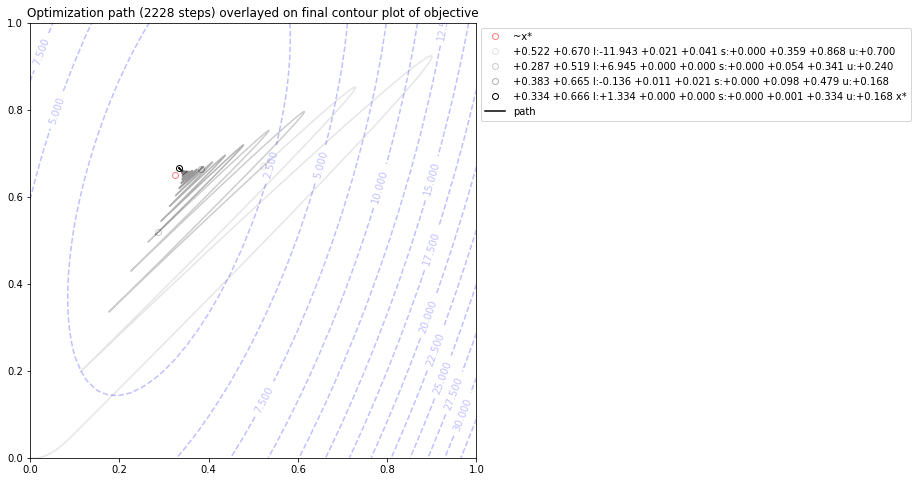

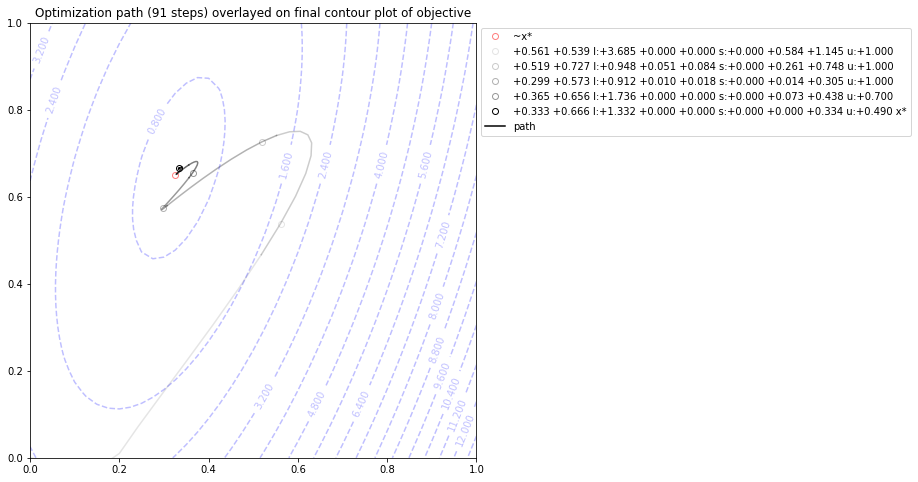

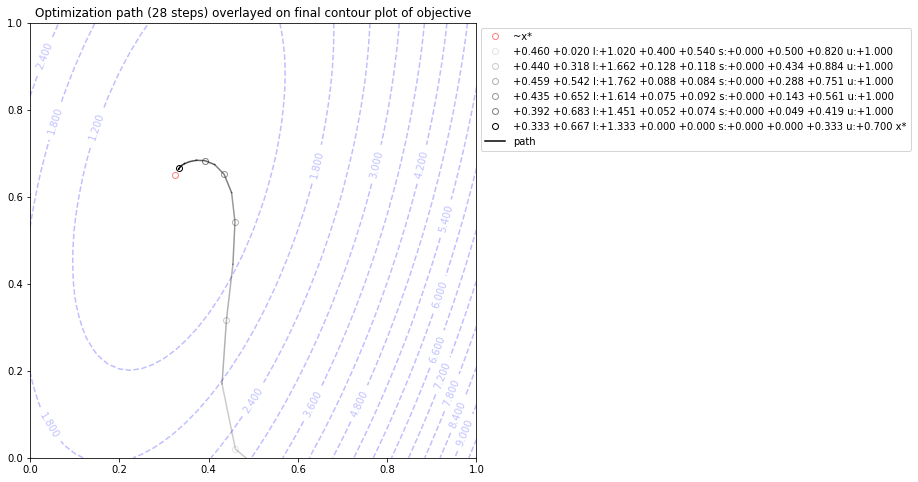

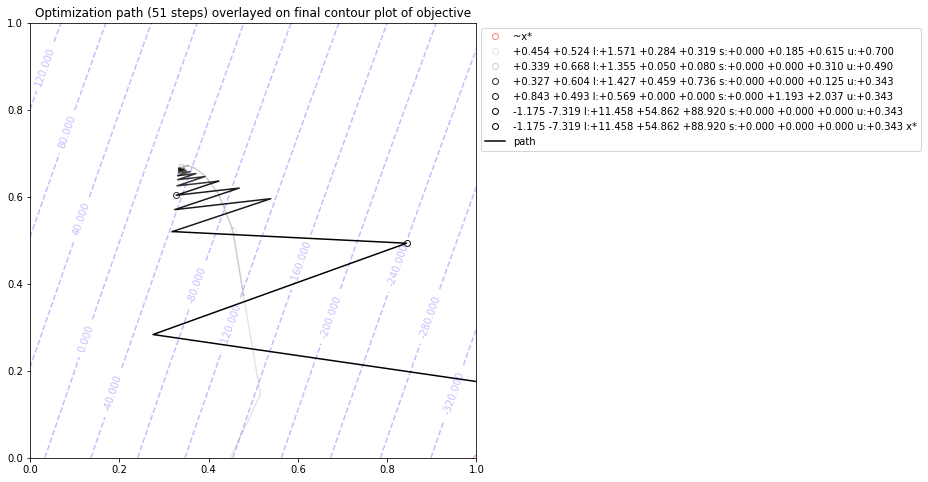

In [196]:
qpp = qppenalty()
optpath = qpp.main("problem06.txt", ['-rate', '0.001', '-epochs', '10000'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem06.txt", pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem06.txt", ['-rate', '0.1'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem06.txt", ['-rate', '0.15', '-epochs', '50'], pathp=True)
plot(qpp, optpath)

Setting $\tau$ is less sensitive. If the value is too large, the minimum will not be found.
If the value is too small, more steps will be required to locate the minimum.
Recall that the minimum of each $P_\mu$ must be solved.
Note that the contour shapes are similar except of the very large $\tau$ value.
Also note that $\tau$ is about the number of digits of precision in the answer.

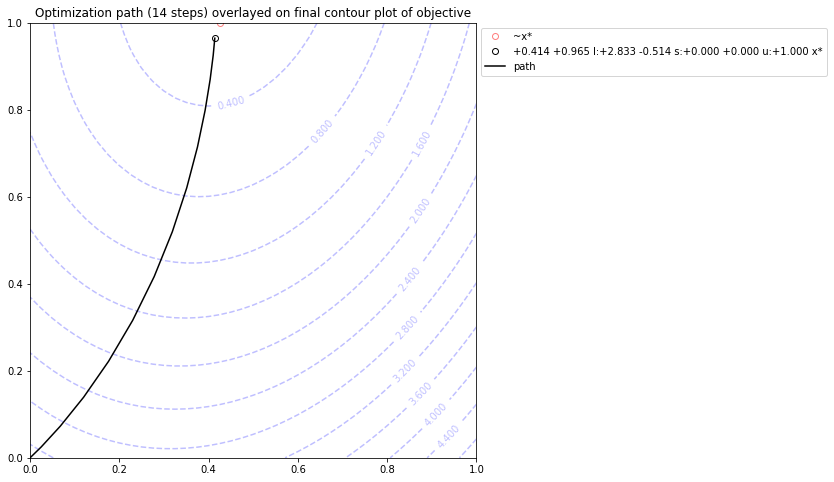

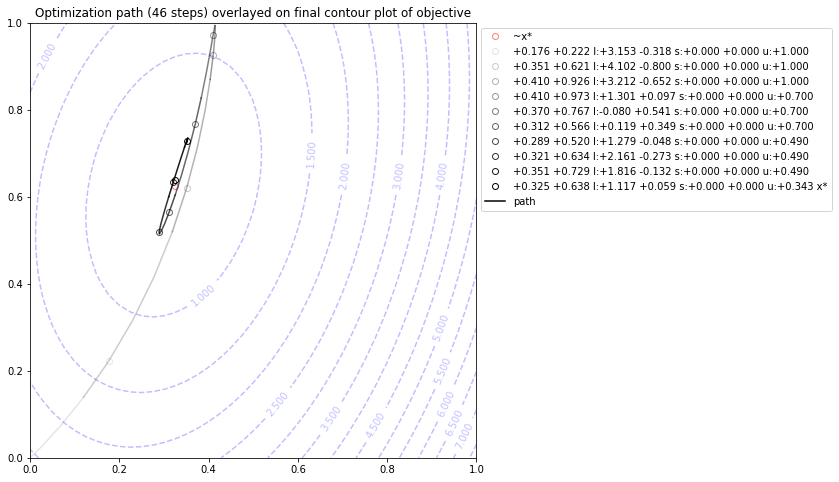

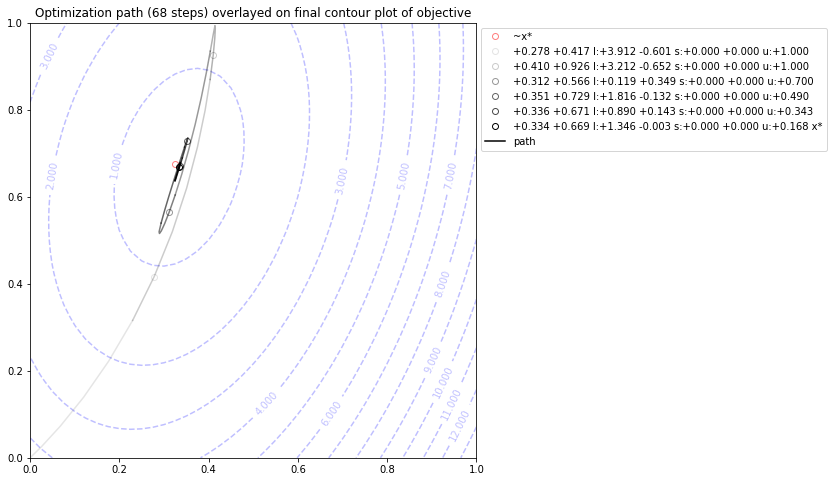

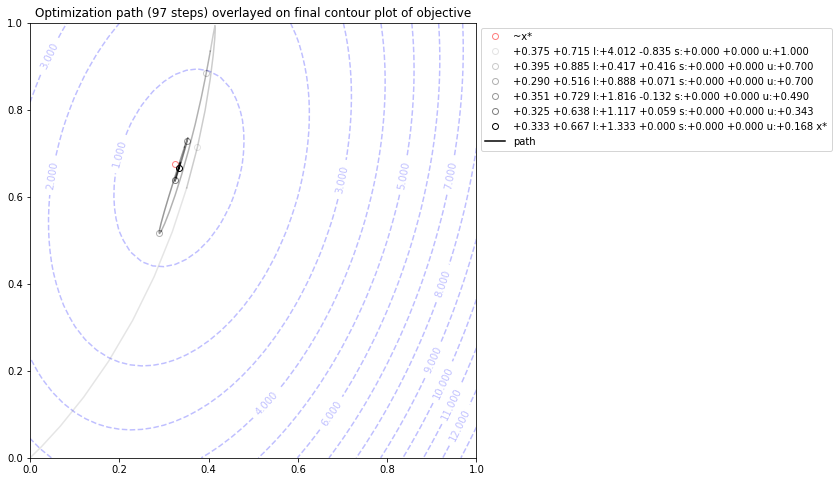

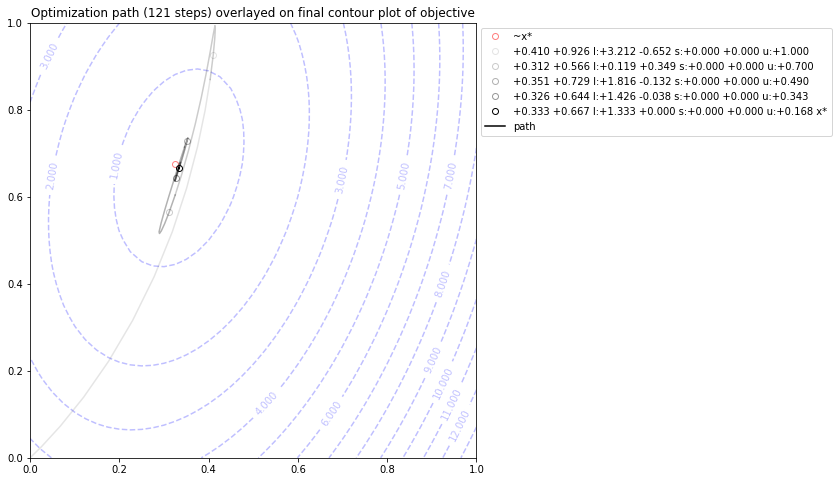

In [197]:
qpp = qppenalty()
optpath = qpp.main("problem03.txt", ['-tau', '1'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", ['-tau', '0.1'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", ['-tau', '0.0001'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", ['-tau', '0.000001'], pathp=True)
plot(qpp, optpath)

Setting the rate to be the same magnitude as $\tau$, seems to be a slow, but working, solution.
Note the significantly smaller values of $\mu$ required for smaller $\tau$.

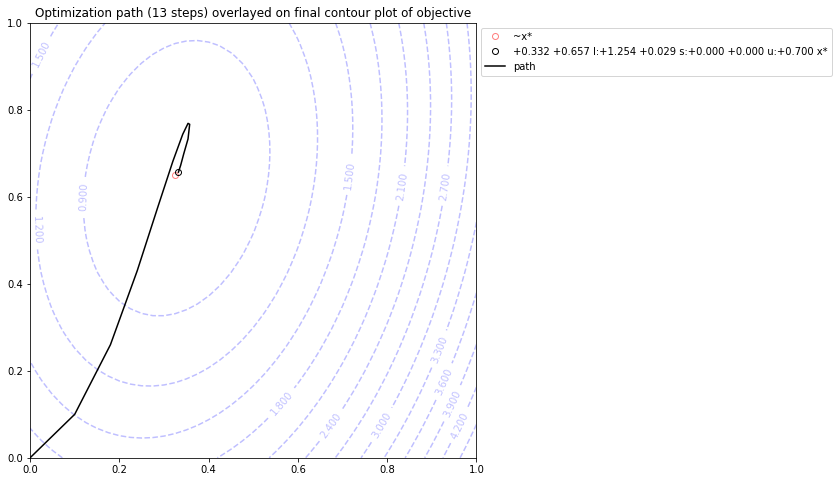

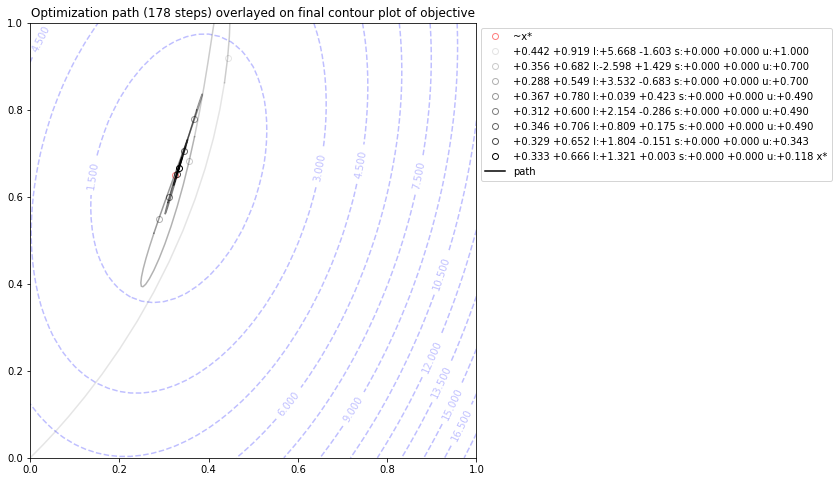

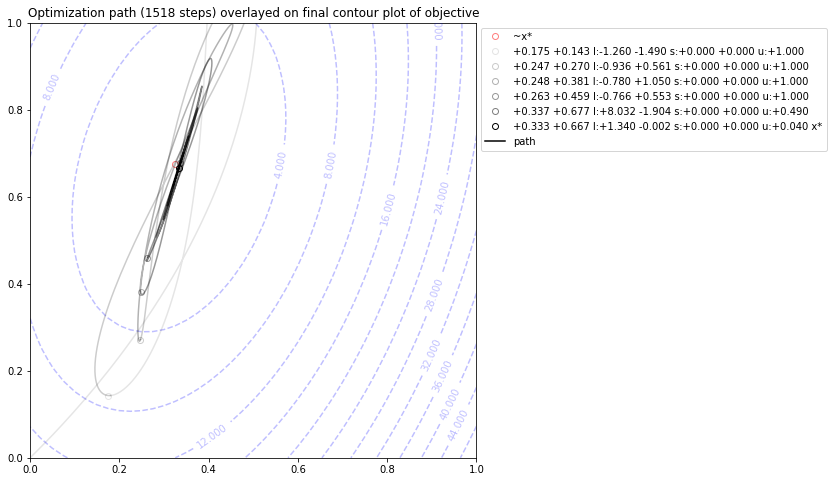

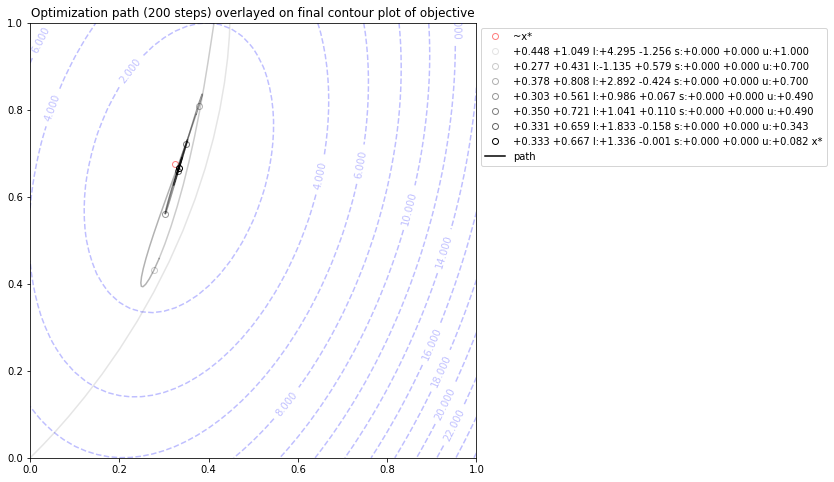

In [198]:
qpp = qppenalty()
optpath = qpp.main("problem03.txt", ['-tau', '0.1', '-rate', '0.1', '-epochs', '2000'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", ['-tau', '0.01', '-rate', '0.01', '-epochs', '2000'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", ['-tau', '0.001', '-rate', '0.001', '-epochs', '2000'], pathp=True)
plot(qpp, optpath)
optpath = qpp.main("problem03.txt", ['-tau', '0.001', '-rate', '0.01', '-epochs', '2000'], pathp=True)
plot(qpp, optpath)